In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Thu Sep 19 23:19:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   47C    P8              22W / 215W |    509MiB /  8192MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
os.chdir('../IConNet')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
dataset = 'text_emotion'
input_feature = 'signals_3channels_win5stride1'
output_label = 'labels_13emotions'
data_dir = f'../data/nlp/{dataset}/'
dataset = 'text_emotion'
input_feature = 'signals_3channels_win5stride1'
output_label = 'labels_13emotions'
data_dir = f'../data/nlp/{dataset}/'
data_path_prefix = f'{data_dir}preprocessed/{dataset}'
x_train = np.load(f'{data_path_prefix}.{input_feature}.train.npy', allow_pickle=True)
x_test = np.load(f'{data_path_prefix}.{input_feature}.test.npy', allow_pickle=True)
labels = np.load(f'{data_path_prefix}.classnames.npy', allow_pickle=True)
y_train = np.load(f'{data_path_prefix}.{output_label}.test.npy', allow_pickle=True)
y_test = np.load(f'{data_path_prefix}.{output_label}.test.npy', allow_pickle=True)
print(f'Train: {x_train.shape}\t Test: {x_test.shape}')
print(f'Class names: {labels}')

Train: (8000, 3, 1024)	 Test: (8000, 3, 1024)
Class names: ['anger' 'boredom' 'empty' 'enthusiasm' 'fun' 'happiness' 'hate' 'love'
 'neutral' 'relief' 'sadness' 'surprise' 'worry']


In [7]:
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train, dtype=torch.float)
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test, dtype=torch.float)
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
    return train_loader, test_loader

batch_size = 128
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)

In [8]:
from IConNet.nn.model import M11
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m11text.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M11Text', 'description': '2-layer FirConv with LSTM for text emotion classification', 'fe': {'n_block': 2, 'n_channel': [128, 128], 'kernel_size': [511, 127], 'stride': [2, 8], 'window_k': [2, 9], 'residual_connection_type': 'channel_concat', 'pooling': 'max', 'mel_resolution': 4, 'filter_type': 'firwin', 'conv_mode': 'strided_conv', 'norm_type': 'LocalResponNorm'}, 'seq': {'n_block': 2, 'n_channel': 64, 'bidirectional': False}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256]}}

In [9]:
model = M11(config=model_config,
           n_input=3, n_output=len(labels))
model

M11(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (seq_blocks): Seq2SeqBlocks(
    (blocks): LSTM(128, 64, num_layers=2, batch_first=True)
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=13, bias=True)
  )
)

In [10]:
layer = model.fe_blocks.blocks[0].layer
from IConNet.visualizer import visualize_model
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000],
        [0.0036, 0.0036, 0.0036],
        [0.0075, 0.0075, 0.0075],
        [0.0117, 0.0117, 0.0117],
        [0.0162, 0.0162, 0.0162],
        [0.0211, 0.0211, 0.0211],
        [0.0264, 0.0264, 0.0264],
        [0.0322, 0.0322, 0.0322],
        [0.0384, 0.0384, 0.0384],
        [0.0451, 0.0451, 0.0451],
        [0.0524, 0.0524, 0.0524],
        [0.0603, 0.0603, 0.0603],
        [0.0688, 0.0688, 0.0688],
        [0.0780, 0.0780, 0.0780],
        [0.0880, 0.0880, 0.0880],
        [0.0988, 0.0988, 0.0988],
        [0.1105, 0.1105, 0.1105],
        [0.1231, 0.1231, 0.1231],
        [0.1368, 0.1368, 0.1368],
        [0.1516, 0.1516, 0.1516],
        [0.1676, 0.1676, 0.1676],
        [0.1849, 0.1849, 0.1849],
        [0.2036, 0.2036, 0.2036],
        [0.2239, 0.2239, 0.2239],
        [0.2458, 0.2458, 0.2458],
        [0.2696, 0.2696, 0.2696],
        [0.2952, 0.2952, 0.2952],
        [0.3230, 0.3230, 0.3230],
        [

In [11]:
print(visualize_model.count_parameters(model))

351117


In [12]:
visualize_model.count_parameters(model.fe_blocks)

181760

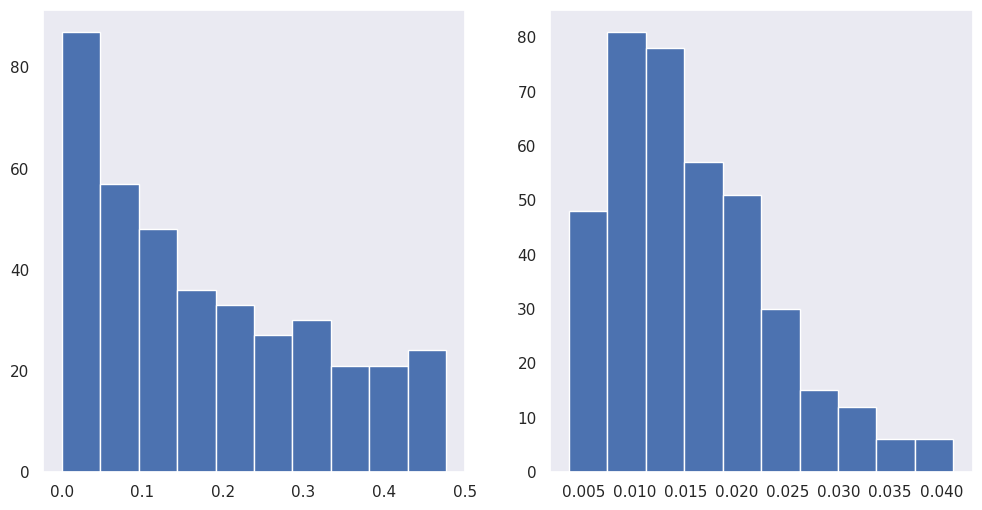

In [13]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = 20
)
filtviz.visualize_bands()

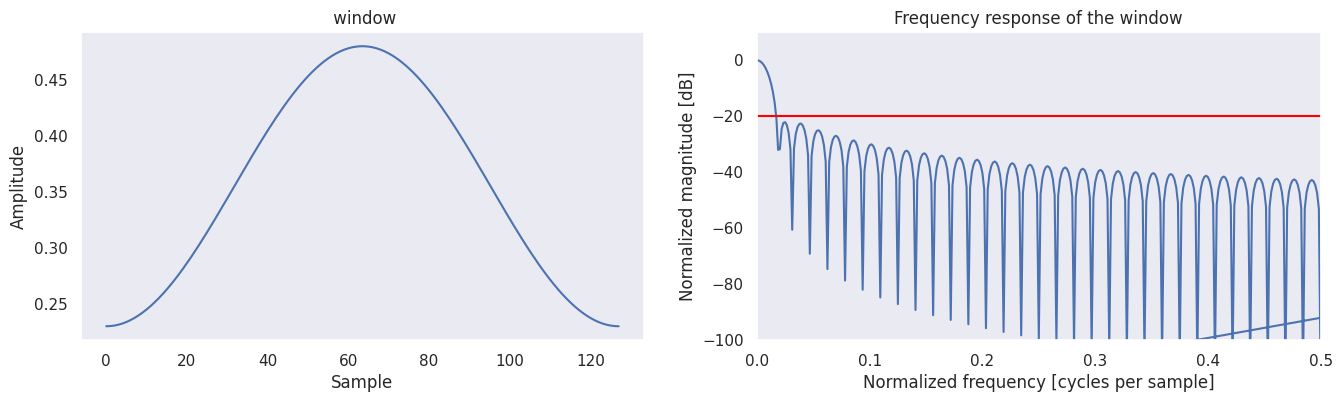

In [14]:
filtviz.visualize_one_window()

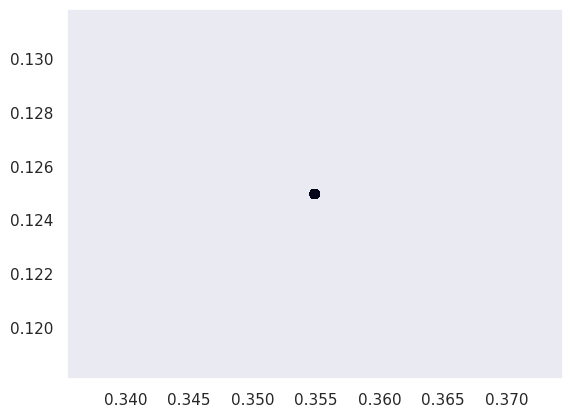

In [15]:
filtviz.visualize_window_params()

In [16]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data_length = len(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        del data
        gc.collect()
        torch.cuda.empty_cache()
        loss = F.cross_entropy(output.squeeze(), target)
        del target
        gc.collect()
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if batch_idx % log_interval*10 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")

        pbar.update(pbar_update)
        train_losses.append(loss.item())

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [17]:
n_epoch = 500
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [18]:
log_interval = 100
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                       | 0.015873015873015872/500 [00:00<5:07:31, 36.90s/it]

Train Epoch: 1 [0/8000 (0%)]	Loss: 2.608812


  0%|                                         | 1.0079365079365052/500 [00:21<2:50:36, 20.51s/it]


Test Epoch: 1	Accuracy: 1859/8000 (23%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 2.136025


  0%|▏                                        | 2.0079365079365017/500 [00:42<2:48:35, 20.31s/it]


Test Epoch: 2	Accuracy: 1963/8000 (25%)

Train Epoch: 3 [0/8000 (0%)]	Loss: 2.095437


  1%|▎                                         | 3.007936507936498/500 [01:03<2:53:20, 20.93s/it]


Test Epoch: 3	Accuracy: 1961/8000 (25%)

Train Epoch: 4 [0/8000 (0%)]	Loss: 2.174710


  1%|▎                                         | 4.007936507936495/500 [01:24<2:48:45, 20.42s/it]


Test Epoch: 4	Accuracy: 1949/8000 (24%)

Train Epoch: 5 [0/8000 (0%)]	Loss: 2.252197


  1%|▍                                         | 5.007936507936491/500 [01:45<2:48:40, 20.45s/it]


Test Epoch: 5	Accuracy: 2001/8000 (25%)

Train Epoch: 6 [0/8000 (0%)]	Loss: 2.153256


  1%|▍                                        | 6.0079365079364875/500 [02:06<2:46:44, 20.25s/it]


Test Epoch: 6	Accuracy: 2005/8000 (25%)

Train Epoch: 7 [0/8000 (0%)]	Loss: 1.993672


  1%|▌                                         | 7.007936507936484/500 [02:27<2:52:43, 21.02s/it]


Test Epoch: 7	Accuracy: 2008/8000 (25%)

Train Epoch: 8 [0/8000 (0%)]	Loss: 2.111283


  2%|▋                                         | 8.007936507936481/500 [02:49<2:48:51, 20.59s/it]


Test Epoch: 8	Accuracy: 2014/8000 (25%)

Train Epoch: 9 [0/8000 (0%)]	Loss: 2.118975


  2%|▊                                         | 9.007936507936478/500 [03:10<2:50:02, 20.78s/it]


Test Epoch: 9	Accuracy: 1805/8000 (23%)

Train Epoch: 10 [0/8000 (0%)]	Loss: 2.174417


  2%|▊                                        | 10.007936507936474/500 [03:31<2:50:40, 20.90s/it]


Test Epoch: 10	Accuracy: 1930/8000 (24%)

Train Epoch: 11 [0/8000 (0%)]	Loss: 1.983882


  2%|▉                                         | 11.00793650793647/500 [03:52<2:52:05, 21.12s/it]


Test Epoch: 11	Accuracy: 1955/8000 (24%)

Train Epoch: 12 [0/8000 (0%)]	Loss: 2.201090


  2%|▉                                        | 12.007936507936467/500 [04:14<2:47:56, 20.65s/it]


Test Epoch: 12	Accuracy: 1897/8000 (24%)

Train Epoch: 13 [0/8000 (0%)]	Loss: 2.251287


  3%|█                                        | 13.007936507936463/500 [04:35<2:48:11, 20.72s/it]


Test Epoch: 13	Accuracy: 1932/8000 (24%)

Train Epoch: 14 [0/8000 (0%)]	Loss: 2.031604


  3%|█▏                                        | 14.00793650793646/500 [04:56<2:44:11, 20.27s/it]


Test Epoch: 14	Accuracy: 2038/8000 (25%)

Train Epoch: 15 [0/8000 (0%)]	Loss: 2.091363


  3%|█▏                                       | 15.007936507936456/500 [05:17<2:52:25, 21.33s/it]


Test Epoch: 15	Accuracy: 2011/8000 (25%)

Train Epoch: 16 [0/8000 (0%)]	Loss: 2.112321


  3%|█▎                                       | 16.007936507936453/500 [05:38<2:47:14, 20.73s/it]


Test Epoch: 16	Accuracy: 1907/8000 (24%)

Train Epoch: 17 [0/8000 (0%)]	Loss: 2.184319


  3%|█▍                                       | 17.007936507936673/500 [05:59<2:47:19, 20.79s/it]


Test Epoch: 17	Accuracy: 1906/8000 (24%)

Train Epoch: 18 [0/8000 (0%)]	Loss: 2.206127


  4%|█▍                                       | 18.007936507936893/500 [06:21<2:47:11, 20.81s/it]


Test Epoch: 18	Accuracy: 1895/8000 (24%)

Train Epoch: 19 [0/8000 (0%)]	Loss: 2.022536


  4%|█▌                                       | 19.007936507937114/500 [06:42<2:45:23, 20.63s/it]


Test Epoch: 19	Accuracy: 2018/8000 (25%)

Train Epoch: 20 [0/8000 (0%)]	Loss: 2.135253


  4%|█▋                                       | 20.007936507937334/500 [07:03<2:42:39, 20.33s/it]


Test Epoch: 20	Accuracy: 1955/8000 (24%)

Train Epoch: 21 [0/8000 (0%)]	Loss: 2.079420


  4%|█▋                                       | 21.007936507937554/500 [07:24<2:42:46, 20.39s/it]


Test Epoch: 21	Accuracy: 2035/8000 (25%)

Train Epoch: 22 [0/8000 (0%)]	Loss: 2.133379


  4%|█▊                                       | 22.007936507937774/500 [07:45<2:43:49, 20.56s/it]


Test Epoch: 22	Accuracy: 2022/8000 (25%)

Train Epoch: 23 [0/8000 (0%)]	Loss: 2.116099


  5%|█▉                                       | 23.007936507937995/500 [08:06<2:41:49, 20.36s/it]


Test Epoch: 23	Accuracy: 2038/8000 (25%)

Train Epoch: 24 [0/8000 (0%)]	Loss: 2.273332


  5%|█▉                                       | 24.007936507938215/500 [08:27<2:42:51, 20.53s/it]


Test Epoch: 24	Accuracy: 1979/8000 (25%)

Train Epoch: 25 [0/8000 (0%)]	Loss: 2.075904


  5%|██                                       | 25.007936507938435/500 [08:48<2:39:57, 20.21s/it]


Test Epoch: 25	Accuracy: 2049/8000 (26%)

Train Epoch: 26 [0/8000 (0%)]	Loss: 2.180344


  5%|██▏                                      | 26.007936507938656/500 [09:09<2:38:06, 20.01s/it]


Test Epoch: 26	Accuracy: 2024/8000 (25%)

Train Epoch: 27 [0/8000 (0%)]	Loss: 2.081572


  5%|██▏                                      | 27.007936507938876/500 [09:30<2:43:03, 20.68s/it]


Test Epoch: 27	Accuracy: 2064/8000 (26%)

Train Epoch: 28 [0/8000 (0%)]	Loss: 2.176098


  6%|██▎                                      | 28.007936507939096/500 [09:51<2:42:27, 20.65s/it]


Test Epoch: 28	Accuracy: 2021/8000 (25%)

Train Epoch: 29 [0/8000 (0%)]	Loss: 2.120015


  6%|██▍                                      | 29.007936507939316/500 [10:13<2:43:43, 20.86s/it]


Test Epoch: 29	Accuracy: 2069/8000 (26%)

Train Epoch: 30 [0/8000 (0%)]	Loss: 2.123242


  6%|██▍                                      | 30.007936507939537/500 [10:34<2:43:00, 20.81s/it]


Test Epoch: 30	Accuracy: 1937/8000 (24%)

Train Epoch: 31 [0/8000 (0%)]	Loss: 2.157840


  6%|██▌                                      | 31.007936507939757/500 [10:55<2:37:04, 20.10s/it]


Test Epoch: 31	Accuracy: 2031/8000 (25%)

Train Epoch: 32 [0/8000 (0%)]	Loss: 2.042547


  6%|██▌                                      | 32.007936507939974/500 [11:16<2:37:45, 20.23s/it]


Test Epoch: 32	Accuracy: 2026/8000 (25%)

Train Epoch: 33 [0/8000 (0%)]	Loss: 2.187214


  7%|██▋                                      | 33.007936507939746/500 [11:37<2:38:53, 20.41s/it]


Test Epoch: 33	Accuracy: 2073/8000 (26%)

Train Epoch: 34 [0/8000 (0%)]	Loss: 2.182887


  7%|██▊                                       | 34.00793650793952/500 [11:58<2:37:49, 20.32s/it]


Test Epoch: 34	Accuracy: 2043/8000 (26%)

Train Epoch: 35 [0/8000 (0%)]	Loss: 2.221812


  7%|██▉                                       | 35.00793650793929/500 [12:19<2:36:15, 20.16s/it]


Test Epoch: 35	Accuracy: 2024/8000 (25%)

Train Epoch: 36 [0/8000 (0%)]	Loss: 2.082922


  7%|██▉                                      | 36.007936507939064/500 [12:40<2:35:54, 20.16s/it]


Test Epoch: 36	Accuracy: 2064/8000 (26%)

Train Epoch: 37 [0/8000 (0%)]	Loss: 2.099504


  7%|███                                       | 37.00793650793884/500 [13:00<2:35:04, 20.10s/it]


Test Epoch: 37	Accuracy: 2067/8000 (26%)

Train Epoch: 38 [0/8000 (0%)]	Loss: 2.310457


  8%|███▏                                      | 38.00793650793861/500 [13:21<2:35:34, 20.21s/it]


Test Epoch: 38	Accuracy: 2051/8000 (26%)

Train Epoch: 39 [0/8000 (0%)]	Loss: 2.100501


  8%|███▎                                      | 39.00793650793838/500 [13:42<2:39:51, 20.81s/it]


Test Epoch: 39	Accuracy: 2025/8000 (25%)

Train Epoch: 40 [0/8000 (0%)]	Loss: 2.048797


  8%|███▎                                     | 40.007936507938155/500 [14:03<2:35:49, 20.33s/it]


Test Epoch: 40	Accuracy: 2073/8000 (26%)

Train Epoch: 41 [0/8000 (0%)]	Loss: 2.085251


  8%|███▍                                      | 41.00793650793793/500 [14:24<2:35:25, 20.32s/it]


Test Epoch: 41	Accuracy: 2055/8000 (26%)

Train Epoch: 42 [0/8000 (0%)]	Loss: 2.169655


  8%|███▌                                       | 42.0079365079377/500 [14:46<2:37:42, 20.66s/it]


Test Epoch: 42	Accuracy: 2083/8000 (26%)

Train Epoch: 43 [0/8000 (0%)]	Loss: 2.119844


  9%|███▌                                      | 43.00793650793747/500 [15:06<2:33:04, 20.10s/it]


Test Epoch: 43	Accuracy: 2073/8000 (26%)

Train Epoch: 44 [0/8000 (0%)]	Loss: 2.167608


  9%|███▌                                     | 44.007936507937245/500 [15:28<2:36:21, 20.57s/it]


Test Epoch: 44	Accuracy: 2059/8000 (26%)

Train Epoch: 45 [0/8000 (0%)]	Loss: 2.216748


  9%|███▊                                      | 45.00793650793702/500 [15:48<2:36:01, 20.58s/it]


Test Epoch: 45	Accuracy: 2083/8000 (26%)

Train Epoch: 46 [0/8000 (0%)]	Loss: 2.083501


  9%|███▊                                      | 46.00793650793679/500 [16:10<2:33:52, 20.34s/it]


Test Epoch: 46	Accuracy: 2098/8000 (26%)

Train Epoch: 47 [0/8000 (0%)]	Loss: 2.117639


  9%|███▉                                      | 47.00793650793656/500 [16:31<2:42:51, 21.57s/it]


Test Epoch: 47	Accuracy: 2074/8000 (26%)

Train Epoch: 48 [0/8000 (0%)]	Loss: 1.954278


 10%|███▉                                     | 48.007936507936336/500 [16:53<2:35:26, 20.64s/it]


Test Epoch: 48	Accuracy: 2069/8000 (26%)

Train Epoch: 49 [0/8000 (0%)]	Loss: 2.120317


 10%|████                                      | 49.00793650793611/500 [17:14<2:36:57, 20.88s/it]


Test Epoch: 49	Accuracy: 2103/8000 (26%)

Train Epoch: 50 [0/8000 (0%)]	Loss: 2.151504


 10%|████▏                                     | 50.00793650793588/500 [17:35<2:29:49, 19.98s/it]


Test Epoch: 50	Accuracy: 2143/8000 (27%)

Train Epoch: 51 [0/8000 (0%)]	Loss: 2.048334


 10%|████▎                                     | 50.99999999999915/500 [17:55<2:23:38, 19.19s/it]


Test Epoch: 51	Accuracy: 2128/8000 (27%)



 10%|████▎                                     | 51.01587301587216/500 [17:56<2:38:52, 21.23s/it]

Train Epoch: 52 [0/8000 (0%)]	Loss: 2.122524


 10%|████▎                                    | 52.007936507935426/500 [18:17<2:32:32, 20.43s/it]


Test Epoch: 52	Accuracy: 2125/8000 (27%)

Train Epoch: 53 [0/8000 (0%)]	Loss: 2.080455


 11%|████▌                                      | 53.0079365079352/500 [18:38<2:30:19, 20.18s/it]


Test Epoch: 53	Accuracy: 2121/8000 (27%)

Train Epoch: 54 [0/8000 (0%)]	Loss: 2.001380


 11%|████▌                                     | 54.00793650793497/500 [18:59<2:32:33, 20.52s/it]


Test Epoch: 54	Accuracy: 2145/8000 (27%)

Train Epoch: 55 [0/8000 (0%)]	Loss: 2.015920


 11%|████▌                                    | 55.007936507934744/500 [19:20<2:34:43, 20.86s/it]


Test Epoch: 55	Accuracy: 2083/8000 (26%)

Train Epoch: 56 [0/8000 (0%)]	Loss: 2.022043


 11%|████▋                                     | 56.00793650793452/500 [19:41<2:31:25, 20.46s/it]


Test Epoch: 56	Accuracy: 2170/8000 (27%)

Train Epoch: 57 [0/8000 (0%)]	Loss: 2.141335


 11%|████▊                                     | 57.00793650793429/500 [20:02<2:29:36, 20.26s/it]


Test Epoch: 57	Accuracy: 2176/8000 (27%)

Train Epoch: 58 [0/8000 (0%)]	Loss: 2.074186


 12%|████▊                                     | 58.00793650793406/500 [20:23<2:30:28, 20.43s/it]


Test Epoch: 58	Accuracy: 2130/8000 (27%)

Train Epoch: 59 [0/8000 (0%)]	Loss: 2.019664


 12%|████▊                                    | 59.007936507933834/500 [20:44<2:31:02, 20.55s/it]


Test Epoch: 59	Accuracy: 2171/8000 (27%)

Train Epoch: 60 [0/8000 (0%)]	Loss: 2.057326


 12%|█████                                     | 60.00793650793361/500 [21:06<2:32:42, 20.82s/it]


Test Epoch: 60	Accuracy: 2218/8000 (28%)

Train Epoch: 61 [0/8000 (0%)]	Loss: 2.054003


 12%|█████                                     | 61.00793650793338/500 [21:27<2:31:18, 20.68s/it]


Test Epoch: 61	Accuracy: 2228/8000 (28%)

Train Epoch: 62 [0/8000 (0%)]	Loss: 1.970077


 12%|█████▏                                    | 62.00793650793315/500 [21:48<2:32:37, 20.91s/it]


Test Epoch: 62	Accuracy: 2208/8000 (28%)

Train Epoch: 63 [0/8000 (0%)]	Loss: 1.922927


 13%|█████▏                                   | 63.007936507932925/500 [22:10<2:30:13, 20.63s/it]


Test Epoch: 63	Accuracy: 2252/8000 (28%)

Train Epoch: 64 [0/8000 (0%)]	Loss: 1.982408


 13%|█████▌                                     | 64.0079365079327/500 [22:31<2:30:22, 20.69s/it]


Test Epoch: 64	Accuracy: 2267/8000 (28%)

Train Epoch: 65 [0/8000 (0%)]	Loss: 1.950295


 13%|█████▍                                    | 65.00793650793247/500 [22:52<2:30:32, 20.77s/it]


Test Epoch: 65	Accuracy: 2324/8000 (29%)

Train Epoch: 66 [0/8000 (0%)]	Loss: 2.069276


 13%|█████▌                                    | 66.00793650793224/500 [23:14<2:29:30, 20.67s/it]


Test Epoch: 66	Accuracy: 2300/8000 (29%)

Train Epoch: 67 [0/8000 (0%)]	Loss: 2.138852


 13%|█████▋                                    | 67.00793650793202/500 [23:35<2:31:02, 20.93s/it]


Test Epoch: 67	Accuracy: 2312/8000 (29%)

Train Epoch: 68 [0/8000 (0%)]	Loss: 2.047519


 14%|█████▋                                    | 68.00793650793179/500 [23:56<2:29:03, 20.70s/it]


Test Epoch: 68	Accuracy: 2364/8000 (30%)

Train Epoch: 69 [0/8000 (0%)]	Loss: 1.944779


 14%|█████▊                                    | 69.00793650793156/500 [24:17<2:28:46, 20.71s/it]


Test Epoch: 69	Accuracy: 2410/8000 (30%)

Train Epoch: 70 [0/8000 (0%)]	Loss: 1.955229


 14%|█████▉                                    | 70.00793650793133/500 [24:39<2:27:29, 20.58s/it]


Test Epoch: 70	Accuracy: 2400/8000 (30%)

Train Epoch: 71 [0/8000 (0%)]	Loss: 1.999538


 14%|██████                                     | 71.0079365079311/500 [25:00<2:28:29, 20.77s/it]


Test Epoch: 71	Accuracy: 2391/8000 (30%)

Train Epoch: 72 [0/8000 (0%)]	Loss: 1.891615


 14%|██████                                    | 72.00793650793088/500 [25:21<2:25:53, 20.45s/it]


Test Epoch: 72	Accuracy: 2522/8000 (32%)

Train Epoch: 73 [0/8000 (0%)]	Loss: 1.952594


 15%|██████▏                                   | 73.00793650793065/500 [25:42<2:25:05, 20.39s/it]


Test Epoch: 73	Accuracy: 2482/8000 (31%)

Train Epoch: 74 [0/8000 (0%)]	Loss: 1.996429


 15%|██████▏                                   | 74.00793650793042/500 [26:03<2:29:41, 21.08s/it]


Test Epoch: 74	Accuracy: 2512/8000 (31%)

Train Epoch: 75 [0/8000 (0%)]	Loss: 1.941912


 15%|██████▍                                    | 75.0079365079302/500 [26:24<2:26:45, 20.72s/it]


Test Epoch: 75	Accuracy: 2557/8000 (32%)

Train Epoch: 76 [0/8000 (0%)]	Loss: 1.883239


 15%|██████▍                                   | 76.00793650792997/500 [26:45<2:24:50, 20.50s/it]


Test Epoch: 76	Accuracy: 2653/8000 (33%)

Train Epoch: 77 [0/8000 (0%)]	Loss: 1.925231


 15%|██████▍                                   | 77.00793650792974/500 [27:06<2:23:35, 20.37s/it]


Test Epoch: 77	Accuracy: 2718/8000 (34%)

Train Epoch: 78 [0/8000 (0%)]	Loss: 1.851611


 16%|██████▌                                   | 78.00793650792951/500 [27:27<2:25:31, 20.69s/it]


Test Epoch: 78	Accuracy: 2799/8000 (35%)

Train Epoch: 79 [0/8000 (0%)]	Loss: 1.869514


 16%|██████▋                                   | 79.00793650792929/500 [27:48<2:21:53, 20.22s/it]


Test Epoch: 79	Accuracy: 2709/8000 (34%)

Train Epoch: 80 [0/8000 (0%)]	Loss: 1.890770


 16%|██████▋                                   | 80.00793650792906/500 [28:09<2:21:21, 20.19s/it]


Test Epoch: 80	Accuracy: 2925/8000 (37%)

Train Epoch: 81 [0/8000 (0%)]	Loss: 1.825346


 16%|██████▊                                   | 81.00793650792883/500 [28:30<2:24:05, 20.63s/it]


Test Epoch: 81	Accuracy: 3058/8000 (38%)

Train Epoch: 82 [0/8000 (0%)]	Loss: 1.800826


 16%|███████                                    | 82.0079365079286/500 [28:50<2:20:37, 20.19s/it]


Test Epoch: 82	Accuracy: 3020/8000 (38%)

Train Epoch: 83 [0/8000 (0%)]	Loss: 1.630824


 17%|██████▉                                   | 83.00793650792838/500 [29:11<2:22:47, 20.55s/it]


Test Epoch: 83	Accuracy: 3064/8000 (38%)

Train Epoch: 84 [0/8000 (0%)]	Loss: 1.701065


 17%|███████                                   | 84.00793650792815/500 [29:32<2:21:32, 20.41s/it]


Test Epoch: 84	Accuracy: 3168/8000 (40%)

Train Epoch: 85 [0/8000 (0%)]	Loss: 1.619206


 17%|███████▏                                  | 85.00793650792792/500 [29:53<2:23:22, 20.73s/it]


Test Epoch: 85	Accuracy: 3149/8000 (39%)

Train Epoch: 86 [0/8000 (0%)]	Loss: 1.753931


 17%|███████▍                                   | 86.0079365079277/500 [30:14<2:18:11, 20.03s/it]


Test Epoch: 86	Accuracy: 3321/8000 (42%)

Train Epoch: 87 [0/8000 (0%)]	Loss: 1.664101


 17%|███████▎                                  | 87.00793650792747/500 [30:35<2:19:45, 20.30s/it]


Test Epoch: 87	Accuracy: 3313/8000 (41%)

Train Epoch: 88 [0/8000 (0%)]	Loss: 1.684240


 18%|███████▍                                  | 88.00793650792724/500 [30:56<2:18:12, 20.13s/it]


Test Epoch: 88	Accuracy: 3459/8000 (43%)

Train Epoch: 89 [0/8000 (0%)]	Loss: 1.635315


 18%|███████▍                                  | 89.00793650792701/500 [31:17<2:19:42, 20.39s/it]


Test Epoch: 89	Accuracy: 3472/8000 (43%)

Train Epoch: 90 [0/8000 (0%)]	Loss: 1.496109


 18%|███████▌                                  | 90.00793650792679/500 [31:39<2:22:02, 20.79s/it]


Test Epoch: 90	Accuracy: 3646/8000 (46%)

Train Epoch: 91 [0/8000 (0%)]	Loss: 1.550349


 18%|███████▋                                  | 91.00793650792656/500 [32:01<2:22:46, 20.95s/it]


Test Epoch: 91	Accuracy: 3721/8000 (47%)

Train Epoch: 92 [0/8000 (0%)]	Loss: 1.504088


 18%|███████▋                                  | 92.00793650792633/500 [32:22<2:25:31, 21.40s/it]


Test Epoch: 92	Accuracy: 3758/8000 (47%)

Train Epoch: 93 [0/8000 (0%)]	Loss: 1.310483


 19%|███████▉                                   | 93.0079365079261/500 [32:44<2:23:04, 21.09s/it]


Test Epoch: 93	Accuracy: 3769/8000 (47%)

Train Epoch: 94 [0/8000 (0%)]	Loss: 1.470796


 19%|███████▉                                  | 94.00793650792588/500 [33:06<2:25:24, 21.49s/it]


Test Epoch: 94	Accuracy: 3980/8000 (50%)

Train Epoch: 95 [0/8000 (0%)]	Loss: 1.546182


 19%|███████▉                                  | 95.00793650792565/500 [33:27<2:20:12, 20.77s/it]


Test Epoch: 95	Accuracy: 4152/8000 (52%)

Train Epoch: 96 [0/8000 (0%)]	Loss: 1.307135


 19%|████████                                  | 96.00793650792542/500 [33:49<2:20:39, 20.89s/it]


Test Epoch: 96	Accuracy: 4196/8000 (52%)

Train Epoch: 97 [0/8000 (0%)]	Loss: 1.395197


 19%|████████▏                                 | 96.99999999998869/500 [34:10<2:12:47, 19.77s/it]


Test Epoch: 97	Accuracy: 4306/8000 (54%)



 19%|████████▎                                  | 97.0158730158617/500 [34:11<2:27:37, 21.98s/it]

Train Epoch: 98 [0/8000 (0%)]	Loss: 1.238432


 20%|████████▏                                 | 98.00793650792497/500 [34:32<2:15:15, 20.19s/it]


Test Epoch: 98	Accuracy: 4257/8000 (53%)

Train Epoch: 99 [0/8000 (0%)]	Loss: 1.305554


 20%|████████▎                                 | 99.00793650792474/500 [34:53<2:21:40, 21.20s/it]


Test Epoch: 99	Accuracy: 4313/8000 (54%)

Train Epoch: 100 [0/8000 (0%)]	Loss: 1.188056


 20%|████████▏                                | 100.00793650792451/500 [35:14<2:18:34, 20.79s/it]


Test Epoch: 100	Accuracy: 4443/8000 (56%)

Train Epoch: 101 [0/8000 (0%)]	Loss: 1.249043


 20%|████████▎                                | 101.00793650792428/500 [35:35<2:19:31, 20.98s/it]


Test Epoch: 101	Accuracy: 4673/8000 (58%)

Train Epoch: 102 [0/8000 (0%)]	Loss: 1.163342


 20%|████████▎                                | 102.00793650792406/500 [35:56<2:19:14, 20.99s/it]


Test Epoch: 102	Accuracy: 4654/8000 (58%)

Train Epoch: 103 [0/8000 (0%)]	Loss: 1.312764


 21%|████████▍                                | 103.00793650792383/500 [36:18<2:21:58, 21.46s/it]


Test Epoch: 103	Accuracy: 4800/8000 (60%)

Train Epoch: 104 [0/8000 (0%)]	Loss: 1.123634


 21%|████████▋                                 | 104.0079365079236/500 [36:39<2:14:31, 20.38s/it]


Test Epoch: 104	Accuracy: 4754/8000 (59%)

Train Epoch: 105 [0/8000 (0%)]	Loss: 1.004490


 21%|████████▌                                | 105.00793650792338/500 [37:00<2:17:47, 20.93s/it]


Test Epoch: 105	Accuracy: 4968/8000 (62%)

Train Epoch: 106 [0/8000 (0%)]	Loss: 1.195499


 21%|████████▋                                | 106.00793650792315/500 [37:22<2:18:46, 21.13s/it]


Test Epoch: 106	Accuracy: 4902/8000 (61%)

Train Epoch: 107 [0/8000 (0%)]	Loss: 1.022768


 21%|████████▊                                | 107.00793650792292/500 [37:43<2:14:30, 20.54s/it]


Test Epoch: 107	Accuracy: 4983/8000 (62%)

Train Epoch: 108 [0/8000 (0%)]	Loss: 1.213359


 22%|█████████                                 | 108.0079365079227/500 [38:05<2:14:03, 20.52s/it]


Test Epoch: 108	Accuracy: 4968/8000 (62%)

Train Epoch: 109 [0/8000 (0%)]	Loss: 0.937521


 22%|████████▉                                | 109.00793650792247/500 [38:26<2:11:59, 20.26s/it]


Test Epoch: 109	Accuracy: 5101/8000 (64%)

Train Epoch: 110 [0/8000 (0%)]	Loss: 1.120481


 22%|█████████                                | 110.00793650792224/500 [38:47<2:12:38, 20.41s/it]


Test Epoch: 110	Accuracy: 5211/8000 (65%)

Train Epoch: 111 [0/8000 (0%)]	Loss: 1.057947


 22%|█████████                                | 111.00793650792201/500 [39:08<2:15:20, 20.88s/it]


Test Epoch: 111	Accuracy: 5283/8000 (66%)

Train Epoch: 112 [0/8000 (0%)]	Loss: 1.108714


 22%|█████████▏                               | 112.00793650792178/500 [39:29<2:13:38, 20.67s/it]


Test Epoch: 112	Accuracy: 5176/8000 (65%)

Train Epoch: 113 [0/8000 (0%)]	Loss: 0.940197


 23%|█████████▎                               | 113.00793650792156/500 [39:50<2:12:59, 20.62s/it]


Test Epoch: 113	Accuracy: 5205/8000 (65%)

Train Epoch: 114 [0/8000 (0%)]	Loss: 1.020431


 23%|█████████▎                               | 114.00793650792133/500 [40:11<2:12:38, 20.62s/it]


Test Epoch: 114	Accuracy: 5388/8000 (67%)

Train Epoch: 115 [0/8000 (0%)]	Loss: 0.950050


 23%|█████████▋                                | 115.0079365079211/500 [40:32<2:11:51, 20.55s/it]


Test Epoch: 115	Accuracy: 5353/8000 (67%)

Train Epoch: 116 [0/8000 (0%)]	Loss: 0.855145


 23%|█████████▌                               | 116.00793650792087/500 [40:53<2:12:09, 20.65s/it]


Test Epoch: 116	Accuracy: 5566/8000 (70%)

Train Epoch: 117 [0/8000 (0%)]	Loss: 0.765379


 23%|█████████▌                               | 117.00793650792065/500 [41:14<2:08:57, 20.20s/it]


Test Epoch: 117	Accuracy: 5609/8000 (70%)

Train Epoch: 118 [0/8000 (0%)]	Loss: 0.939059


 24%|█████████▋                               | 118.00793650792042/500 [41:35<2:08:59, 20.26s/it]


Test Epoch: 118	Accuracy: 5531/8000 (69%)

Train Epoch: 119 [0/8000 (0%)]	Loss: 0.767766


 24%|█████████▊                               | 119.00793650792019/500 [41:56<2:10:23, 20.53s/it]


Test Epoch: 119	Accuracy: 5679/8000 (71%)

Train Epoch: 120 [0/8000 (0%)]	Loss: 0.933060


 24%|█████████▊                               | 120.00793650791996/500 [42:17<2:09:45, 20.49s/it]


Test Epoch: 120	Accuracy: 5554/8000 (69%)

Train Epoch: 121 [0/8000 (0%)]	Loss: 0.925105


 24%|█████████▉                               | 121.00793650791974/500 [42:38<2:09:25, 20.49s/it]


Test Epoch: 121	Accuracy: 5535/8000 (69%)

Train Epoch: 122 [0/8000 (0%)]	Loss: 0.748976


 24%|██████████                               | 122.00793650791951/500 [42:59<2:08:21, 20.37s/it]


Test Epoch: 122	Accuracy: 5620/8000 (70%)

Train Epoch: 123 [0/8000 (0%)]	Loss: 0.787150


 25%|██████████                               | 123.00793650791928/500 [43:20<2:09:07, 20.55s/it]


Test Epoch: 123	Accuracy: 5536/8000 (69%)

Train Epoch: 124 [0/8000 (0%)]	Loss: 0.942588


 25%|██████████▏                              | 124.00793650791906/500 [43:41<2:07:33, 20.36s/it]


Test Epoch: 124	Accuracy: 5817/8000 (73%)

Train Epoch: 125 [0/8000 (0%)]	Loss: 0.780975


 25%|██████████▎                              | 125.00793650791883/500 [44:02<2:08:05, 20.49s/it]


Test Epoch: 125	Accuracy: 5967/8000 (75%)

Train Epoch: 126 [0/8000 (0%)]	Loss: 0.757969


 25%|██████████▌                               | 126.0079365079186/500 [44:23<2:07:12, 20.41s/it]


Test Epoch: 126	Accuracy: 5938/8000 (74%)

Train Epoch: 127 [0/8000 (0%)]	Loss: 0.757029


 25%|██████████▍                              | 127.00793650791837/500 [44:44<2:05:20, 20.16s/it]


Test Epoch: 127	Accuracy: 5682/8000 (71%)

Train Epoch: 128 [0/8000 (0%)]	Loss: 0.639865


 26%|██████████▍                              | 128.00793650791815/500 [45:05<2:04:59, 20.16s/it]


Test Epoch: 128	Accuracy: 5792/8000 (72%)

Train Epoch: 129 [0/8000 (0%)]	Loss: 0.707808


 26%|██████████▌                              | 129.00793650791792/500 [45:26<2:05:36, 20.31s/it]


Test Epoch: 129	Accuracy: 5954/8000 (74%)

Train Epoch: 130 [0/8000 (0%)]	Loss: 0.726085


 26%|██████████▉                               | 130.0079365079177/500 [45:47<2:06:27, 20.51s/it]


Test Epoch: 130	Accuracy: 5962/8000 (75%)

Train Epoch: 131 [0/8000 (0%)]	Loss: 0.649055


 26%|██████████▋                              | 131.00793650791746/500 [46:07<2:06:42, 20.60s/it]


Test Epoch: 131	Accuracy: 5973/8000 (75%)

Train Epoch: 132 [0/8000 (0%)]	Loss: 0.707738


 26%|██████████▊                              | 132.00793650791724/500 [46:28<2:08:43, 20.99s/it]


Test Epoch: 132	Accuracy: 5965/8000 (75%)

Train Epoch: 133 [0/8000 (0%)]	Loss: 0.735179


 27%|███████████▍                               | 133.007936507917/500 [46:49<2:05:35, 20.53s/it]


Test Epoch: 133	Accuracy: 6020/8000 (75%)

Train Epoch: 134 [0/8000 (0%)]	Loss: 0.642684


 27%|██████████▉                              | 134.00793650791678/500 [47:10<2:06:51, 20.80s/it]


Test Epoch: 134	Accuracy: 6007/8000 (75%)

Train Epoch: 135 [0/8000 (0%)]	Loss: 0.538739


 27%|███████████                              | 135.00793650791655/500 [47:31<2:03:40, 20.33s/it]


Test Epoch: 135	Accuracy: 6085/8000 (76%)

Train Epoch: 136 [0/8000 (0%)]	Loss: 0.614320


 27%|███████████▏                             | 136.00793650791633/500 [47:52<2:04:45, 20.56s/it]


Test Epoch: 136	Accuracy: 6043/8000 (76%)

Train Epoch: 137 [0/8000 (0%)]	Loss: 0.735656


 27%|███████████▌                              | 137.0079365079161/500 [48:13<2:06:35, 20.92s/it]


Test Epoch: 137	Accuracy: 6164/8000 (77%)

Train Epoch: 138 [0/8000 (0%)]	Loss: 0.695947


 28%|███████████▎                             | 138.00793650791587/500 [48:34<2:03:06, 20.41s/it]


Test Epoch: 138	Accuracy: 6232/8000 (78%)

Train Epoch: 139 [0/8000 (0%)]	Loss: 0.681729


 28%|███████████▍                             | 139.00793650791564/500 [48:55<2:01:25, 20.18s/it]


Test Epoch: 139	Accuracy: 6227/8000 (78%)

Train Epoch: 140 [0/8000 (0%)]	Loss: 0.721446


 28%|███████████▍                             | 140.00793650791542/500 [49:16<2:02:35, 20.43s/it]


Test Epoch: 140	Accuracy: 6094/8000 (76%)

Train Epoch: 141 [0/8000 (0%)]	Loss: 0.688618


 28%|███████████▊                              | 141.0079365079152/500 [49:37<2:00:38, 20.16s/it]


Test Epoch: 141	Accuracy: 6213/8000 (78%)

Train Epoch: 142 [0/8000 (0%)]	Loss: 0.708027


 28%|███████████▋                             | 142.00793650791496/500 [49:58<2:00:09, 20.14s/it]


Test Epoch: 142	Accuracy: 6391/8000 (80%)

Train Epoch: 143 [0/8000 (0%)]	Loss: 0.619891


 29%|███████████▋                             | 143.00793650791474/500 [50:19<1:59:08, 20.02s/it]


Test Epoch: 143	Accuracy: 6407/8000 (80%)

Train Epoch: 144 [0/8000 (0%)]	Loss: 0.558256


 29%|████████████                              | 144.0079365079145/500 [50:39<1:59:34, 20.15s/it]


Test Epoch: 144	Accuracy: 6280/8000 (78%)

Train Epoch: 145 [0/8000 (0%)]	Loss: 0.562616


 29%|███████████▉                             | 145.00793650791428/500 [51:00<2:01:18, 20.50s/it]


Test Epoch: 145	Accuracy: 6165/8000 (77%)

Train Epoch: 146 [0/8000 (0%)]	Loss: 0.720181


 29%|███████████▉                             | 146.00793650791405/500 [51:21<2:00:08, 20.36s/it]


Test Epoch: 146	Accuracy: 6132/8000 (77%)

Train Epoch: 147 [0/8000 (0%)]	Loss: 0.658291


 29%|████████████                             | 147.00793650791383/500 [51:42<2:00:00, 20.40s/it]


Test Epoch: 147	Accuracy: 6357/8000 (79%)

Train Epoch: 148 [0/8000 (0%)]	Loss: 0.510213


 30%|████████████▍                             | 148.0079365079136/500 [52:03<1:59:12, 20.32s/it]


Test Epoch: 148	Accuracy: 6398/8000 (80%)

Train Epoch: 149 [0/8000 (0%)]	Loss: 0.536834


 30%|████████████▏                            | 149.00793650791337/500 [52:24<2:00:46, 20.65s/it]


Test Epoch: 149	Accuracy: 6332/8000 (79%)

Train Epoch: 150 [0/8000 (0%)]	Loss: 0.574966


 30%|████████████▎                            | 150.00793650791314/500 [52:45<2:00:35, 20.67s/it]


Test Epoch: 150	Accuracy: 6482/8000 (81%)

Train Epoch: 151 [0/8000 (0%)]	Loss: 0.508201


 30%|████████████▍                            | 151.00793650791292/500 [53:06<2:02:18, 21.03s/it]


Test Epoch: 151	Accuracy: 6424/8000 (80%)

Train Epoch: 152 [0/8000 (0%)]	Loss: 0.527685


 30%|████████████▊                             | 152.0079365079127/500 [53:28<1:59:15, 20.56s/it]


Test Epoch: 152	Accuracy: 6464/8000 (81%)

Train Epoch: 153 [0/8000 (0%)]	Loss: 0.542794


 31%|████████████▌                            | 153.00793650791246/500 [53:49<1:58:02, 20.41s/it]


Test Epoch: 153	Accuracy: 6631/8000 (83%)

Train Epoch: 154 [0/8000 (0%)]	Loss: 0.553083


 31%|████████████▋                            | 154.00793650791223/500 [54:10<1:58:01, 20.47s/it]


Test Epoch: 154	Accuracy: 6572/8000 (82%)

Train Epoch: 155 [0/8000 (0%)]	Loss: 0.757972


 31%|█████████████▎                             | 155.007936507912/500 [54:31<1:57:17, 20.40s/it]


Test Epoch: 155	Accuracy: 6553/8000 (82%)

Train Epoch: 156 [0/8000 (0%)]	Loss: 0.451943


 31%|████████████▊                            | 156.00793650791178/500 [54:52<1:56:30, 20.32s/it]


Test Epoch: 156	Accuracy: 6410/8000 (80%)

Train Epoch: 157 [0/8000 (0%)]	Loss: 0.465370


 31%|████████████▊                            | 157.00793650791155/500 [55:13<1:57:28, 20.55s/it]


Test Epoch: 157	Accuracy: 6408/8000 (80%)

Train Epoch: 158 [0/8000 (0%)]	Loss: 0.635312


 32%|████████████▉                            | 158.00793650791132/500 [55:34<1:57:28, 20.61s/it]


Test Epoch: 158	Accuracy: 6532/8000 (82%)

Train Epoch: 159 [0/8000 (0%)]	Loss: 0.527876


 32%|█████████████▎                            | 159.0079365079111/500 [55:55<1:58:10, 20.79s/it]


Test Epoch: 159	Accuracy: 6575/8000 (82%)

Train Epoch: 160 [0/8000 (0%)]	Loss: 0.435937


 32%|█████████████                            | 160.00793650791087/500 [56:16<1:56:58, 20.64s/it]


Test Epoch: 160	Accuracy: 6593/8000 (82%)

Train Epoch: 161 [0/8000 (0%)]	Loss: 0.641753


 32%|█████████████▏                           | 161.00793650791064/500 [56:38<1:57:26, 20.79s/it]


Test Epoch: 161	Accuracy: 6667/8000 (83%)

Train Epoch: 162 [0/8000 (0%)]	Loss: 0.420846


 32%|█████████████▎                           | 162.00793650791042/500 [56:58<1:55:34, 20.52s/it]


Test Epoch: 162	Accuracy: 6637/8000 (83%)

Train Epoch: 163 [0/8000 (0%)]	Loss: 0.621686


 33%|█████████████▋                            | 163.0079365079102/500 [57:19<1:56:19, 20.71s/it]


Test Epoch: 163	Accuracy: 6506/8000 (81%)

Train Epoch: 164 [0/8000 (0%)]	Loss: 0.554428


 33%|█████████████▍                           | 164.00793650790996/500 [57:41<1:56:37, 20.83s/it]


Test Epoch: 164	Accuracy: 6501/8000 (81%)

Train Epoch: 165 [0/8000 (0%)]	Loss: 0.610767


 33%|█████████████▌                           | 165.00793650790973/500 [58:02<1:55:07, 20.62s/it]


Test Epoch: 165	Accuracy: 6632/8000 (83%)

Train Epoch: 166 [0/8000 (0%)]	Loss: 0.645053


 33%|█████████████▉                            | 166.0079365079095/500 [58:24<1:55:34, 20.76s/it]


Test Epoch: 166	Accuracy: 6580/8000 (82%)

Train Epoch: 167 [0/8000 (0%)]	Loss: 0.352755


 33%|█████████████▋                           | 167.00793650790928/500 [58:45<1:54:37, 20.65s/it]


Test Epoch: 167	Accuracy: 6762/8000 (85%)

Train Epoch: 168 [0/8000 (0%)]	Loss: 0.485079


 34%|█████████████▊                           | 168.00793650790905/500 [59:06<1:53:21, 20.49s/it]


Test Epoch: 168	Accuracy: 6550/8000 (82%)

Train Epoch: 169 [0/8000 (0%)]	Loss: 0.611868


 34%|█████████████▊                           | 169.00793650790882/500 [59:28<1:53:13, 20.53s/it]


Test Epoch: 169	Accuracy: 6599/8000 (82%)

Train Epoch: 170 [0/8000 (0%)]	Loss: 0.498452


 34%|██████████████▎                           | 170.0079365079086/500 [59:49<1:54:25, 20.81s/it]


Test Epoch: 170	Accuracy: 6556/8000 (82%)

Train Epoch: 171 [0/8000 (0%)]	Loss: 0.600451


 34%|█████████████▎                         | 171.00793650790837/500 [1:00:11<1:52:31, 20.52s/it]


Test Epoch: 171	Accuracy: 6624/8000 (83%)

Train Epoch: 172 [0/8000 (0%)]	Loss: 0.521450


 34%|█████████████▍                         | 172.00793650790814/500 [1:00:32<1:50:34, 20.23s/it]


Test Epoch: 172	Accuracy: 6682/8000 (84%)

Train Epoch: 173 [0/8000 (0%)]	Loss: 0.422774


 35%|█████████████▊                          | 173.0079365079079/500 [1:00:53<1:52:52, 20.71s/it]


Test Epoch: 173	Accuracy: 6754/8000 (84%)

Train Epoch: 174 [0/8000 (0%)]	Loss: 0.476939


 35%|█████████████▉                          | 174.0079365079077/500 [1:01:14<1:50:14, 20.29s/it]


Test Epoch: 174	Accuracy: 6772/8000 (85%)

Train Epoch: 175 [0/8000 (0%)]	Loss: 0.455914


 35%|█████████████▋                         | 175.00793650790746/500 [1:01:35<1:49:21, 20.19s/it]


Test Epoch: 175	Accuracy: 6633/8000 (83%)

Train Epoch: 176 [0/8000 (0%)]	Loss: 0.470560


 35%|█████████████▋                         | 176.00793650790723/500 [1:01:56<1:52:09, 20.77s/it]


Test Epoch: 176	Accuracy: 6845/8000 (86%)

Train Epoch: 177 [0/8000 (0%)]	Loss: 0.398497


 35%|██████████████▌                          | 177.007936507907/500 [1:02:17<1:50:17, 20.49s/it]


Test Epoch: 177	Accuracy: 6868/8000 (86%)

Train Epoch: 178 [0/8000 (0%)]	Loss: 0.427458


 36%|█████████████▉                         | 178.00793650790678/500 [1:02:38<1:48:09, 20.15s/it]


Test Epoch: 178	Accuracy: 6800/8000 (85%)

Train Epoch: 179 [0/8000 (0%)]	Loss: 0.435115


 36%|█████████████▉                         | 179.00793650790655/500 [1:02:59<1:51:06, 20.77s/it]


Test Epoch: 179	Accuracy: 6635/8000 (83%)

Train Epoch: 180 [0/8000 (0%)]	Loss: 0.471362


 36%|██████████████                         | 180.00793650790632/500 [1:03:20<1:52:51, 21.16s/it]


Test Epoch: 180	Accuracy: 6813/8000 (85%)

Train Epoch: 181 [0/8000 (0%)]	Loss: 0.461212


 36%|██████████████▍                         | 181.0079365079061/500 [1:03:42<1:50:12, 20.73s/it]


Test Epoch: 181	Accuracy: 6983/8000 (87%)

Train Epoch: 182 [0/8000 (0%)]	Loss: 0.351630


 36%|██████████████▏                        | 182.00793650790587/500 [1:04:03<1:47:33, 20.30s/it]


Test Epoch: 182	Accuracy: 6845/8000 (86%)

Train Epoch: 183 [0/8000 (0%)]	Loss: 0.337744


 37%|██████████████▎                        | 183.00793650790564/500 [1:04:23<1:47:31, 20.35s/it]


Test Epoch: 183	Accuracy: 6844/8000 (86%)

Train Epoch: 184 [0/8000 (0%)]	Loss: 0.569710


 37%|██████████████▋                         | 184.0079365079054/500 [1:04:45<1:48:31, 20.61s/it]


Test Epoch: 184	Accuracy: 6893/8000 (86%)

Train Epoch: 185 [0/8000 (0%)]	Loss: 0.443506


 37%|██████████████▍                        | 185.00793650790519/500 [1:05:06<1:46:33, 20.30s/it]


Test Epoch: 185	Accuracy: 6996/8000 (87%)

Train Epoch: 186 [0/8000 (0%)]	Loss: 0.293836


 37%|██████████████▌                        | 186.00793650790496/500 [1:05:27<1:46:58, 20.44s/it]


Test Epoch: 186	Accuracy: 7020/8000 (88%)

Train Epoch: 187 [0/8000 (0%)]	Loss: 0.334184


 37%|██████████████▌                        | 187.00793650790473/500 [1:05:47<1:44:19, 20.00s/it]


Test Epoch: 187	Accuracy: 6918/8000 (86%)

Train Epoch: 188 [0/8000 (0%)]	Loss: 0.466772


 38%|███████████████                         | 188.0079365079045/500 [1:06:08<1:46:18, 20.44s/it]


Test Epoch: 188	Accuracy: 6852/8000 (86%)

Train Epoch: 189 [0/8000 (0%)]	Loss: 0.320486


 38%|██████████████▋                        | 189.00793650790428/500 [1:06:29<1:46:16, 20.50s/it]


Test Epoch: 189	Accuracy: 6945/8000 (87%)

Train Epoch: 190 [0/8000 (0%)]	Loss: 0.376856


 38%|██████████████▊                        | 190.00793650790405/500 [1:06:50<1:46:03, 20.53s/it]


Test Epoch: 190	Accuracy: 7056/8000 (88%)

Train Epoch: 191 [0/8000 (0%)]	Loss: 0.371460


 38%|██████████████▉                        | 191.00793650790382/500 [1:07:11<1:44:30, 20.29s/it]


Test Epoch: 191	Accuracy: 6962/8000 (87%)

Train Epoch: 192 [0/8000 (0%)]	Loss: 0.261806


 38%|███████████████▎                        | 192.0079365079036/500 [1:07:32<1:45:36, 20.57s/it]


Test Epoch: 192	Accuracy: 6912/8000 (86%)

Train Epoch: 193 [0/8000 (0%)]	Loss: 0.445502


 39%|███████████████                        | 193.00793650790337/500 [1:07:53<1:45:34, 20.63s/it]


Test Epoch: 193	Accuracy: 7053/8000 (88%)

Train Epoch: 194 [0/8000 (0%)]	Loss: 0.326560


 39%|███████████████▏                       | 194.00793650790314/500 [1:08:14<1:46:00, 20.79s/it]


Test Epoch: 194	Accuracy: 6849/8000 (86%)

Train Epoch: 195 [0/8000 (0%)]	Loss: 0.505212


 39%|███████████████▌                        | 195.0079365079029/500 [1:08:35<1:43:45, 20.41s/it]


Test Epoch: 195	Accuracy: 7015/8000 (88%)

Train Epoch: 196 [0/8000 (0%)]	Loss: 0.423976


 39%|███████████████▎                       | 196.00793650790268/500 [1:08:56<1:41:57, 20.12s/it]


Test Epoch: 196	Accuracy: 7046/8000 (88%)

Train Epoch: 197 [0/8000 (0%)]	Loss: 0.388458


 39%|███████████████▎                       | 197.00793650790246/500 [1:09:16<1:38:39, 19.54s/it]


Test Epoch: 197	Accuracy: 7076/8000 (88%)

Train Epoch: 198 [0/8000 (0%)]	Loss: 0.368284


 40%|███████████████▍                       | 198.00793650790223/500 [1:09:38<1:43:45, 20.62s/it]


Test Epoch: 198	Accuracy: 7144/8000 (89%)

Train Epoch: 199 [0/8000 (0%)]	Loss: 0.340264


 40%|████████████████▎                        | 199.007936507902/500 [1:09:59<1:43:54, 20.71s/it]


Test Epoch: 199	Accuracy: 7059/8000 (88%)

Train Epoch: 200 [0/8000 (0%)]	Loss: 0.401537


 40%|███████████████▌                       | 200.00793650790177/500 [1:10:20<1:42:05, 20.42s/it]


Test Epoch: 200	Accuracy: 6997/8000 (87%)

Train Epoch: 201 [0/8000 (0%)]	Loss: 0.398374


 40%|███████████████▋                       | 201.00793650790155/500 [1:10:41<1:40:58, 20.26s/it]


Test Epoch: 201	Accuracy: 7169/8000 (90%)

Train Epoch: 202 [0/8000 (0%)]	Loss: 0.284459


 40%|███████████████▊                       | 202.00793650790132/500 [1:11:02<1:42:16, 20.59s/it]


Test Epoch: 202	Accuracy: 7152/8000 (89%)

Train Epoch: 203 [0/8000 (0%)]	Loss: 0.258221


 41%|████████████████▏                       | 203.0079365079011/500 [1:11:23<1:40:23, 20.28s/it]


Test Epoch: 203	Accuracy: 7201/8000 (90%)

Train Epoch: 204 [0/8000 (0%)]	Loss: 0.277437


 41%|███████████████▉                       | 204.00793650790087/500 [1:11:43<1:40:34, 20.39s/it]


Test Epoch: 204	Accuracy: 7275/8000 (91%)

Train Epoch: 205 [0/8000 (0%)]	Loss: 0.291485


 41%|███████████████▉                       | 205.00793650790064/500 [1:12:04<1:39:25, 20.22s/it]


Test Epoch: 205	Accuracy: 7112/8000 (89%)

Train Epoch: 206 [0/8000 (0%)]	Loss: 0.304815


 41%|████████████████▍                       | 206.0079365079004/500 [1:12:26<1:47:12, 21.88s/it]


Test Epoch: 206	Accuracy: 7103/8000 (89%)

Train Epoch: 207 [0/8000 (0%)]	Loss: 0.343513


 41%|████████████████▏                      | 207.00793650790018/500 [1:12:47<1:39:36, 20.40s/it]


Test Epoch: 207	Accuracy: 7081/8000 (89%)

Train Epoch: 208 [0/8000 (0%)]	Loss: 0.367776


 42%|████████████████▏                      | 208.00793650789996/500 [1:13:08<1:39:57, 20.54s/it]


Test Epoch: 208	Accuracy: 7149/8000 (89%)

Train Epoch: 209 [0/8000 (0%)]	Loss: 0.270923


 42%|████████████████▎                      | 209.00793650789973/500 [1:13:29<1:39:05, 20.43s/it]


Test Epoch: 209	Accuracy: 7126/8000 (89%)

Train Epoch: 210 [0/8000 (0%)]	Loss: 0.359635


 42%|████████████████▊                       | 210.0079365078995/500 [1:13:50<1:40:27, 20.79s/it]


Test Epoch: 210	Accuracy: 7109/8000 (89%)

Train Epoch: 211 [0/8000 (0%)]	Loss: 0.422408


 42%|████████████████▍                      | 210.99999999996277/500 [1:14:11<1:40:34, 20.88s/it]


Test Epoch: 211	Accuracy: 7121/8000 (89%)



 42%|████████████████▍                      | 211.01587301583578/500 [1:14:11<1:44:16, 21.65s/it]

Train Epoch: 212 [0/8000 (0%)]	Loss: 0.312299


 42%|████████████████▌                      | 212.00793650789905/500 [1:14:33<1:37:55, 20.40s/it]


Test Epoch: 212	Accuracy: 7166/8000 (90%)

Train Epoch: 213 [0/8000 (0%)]	Loss: 0.258219


 43%|████████████████▌                      | 213.00793650789882/500 [1:14:54<1:38:04, 20.51s/it]


Test Epoch: 213	Accuracy: 7167/8000 (90%)

Train Epoch: 214 [0/8000 (0%)]	Loss: 0.215743


 43%|█████████████████                       | 214.0079365078986/500 [1:15:15<1:38:57, 20.76s/it]


Test Epoch: 214	Accuracy: 7250/8000 (91%)

Train Epoch: 215 [0/8000 (0%)]	Loss: 0.285991


 43%|████████████████▊                      | 215.00793650789836/500 [1:15:36<1:37:25, 20.51s/it]


Test Epoch: 215	Accuracy: 7128/8000 (89%)

Train Epoch: 216 [0/8000 (0%)]	Loss: 0.282514


 43%|████████████████▊                      | 216.00793650789814/500 [1:15:57<1:38:01, 20.71s/it]


Test Epoch: 216	Accuracy: 7187/8000 (90%)

Train Epoch: 217 [0/8000 (0%)]	Loss: 0.352248


 43%|█████████████████▎                      | 217.0079365078979/500 [1:16:19<1:37:57, 20.77s/it]


Test Epoch: 217	Accuracy: 7129/8000 (89%)

Train Epoch: 218 [0/8000 (0%)]	Loss: 0.308845


 44%|█████████████████                      | 218.00793650789768/500 [1:16:40<1:38:06, 20.87s/it]


Test Epoch: 218	Accuracy: 6986/8000 (87%)

Train Epoch: 219 [0/8000 (0%)]	Loss: 0.266106


 44%|█████████████████                      | 219.00793650789745/500 [1:17:01<1:35:19, 20.35s/it]


Test Epoch: 219	Accuracy: 6917/8000 (86%)

Train Epoch: 220 [0/8000 (0%)]	Loss: 0.481687


 44%|█████████████████▏                     | 220.00793650789723/500 [1:17:22<1:39:03, 21.23s/it]


Test Epoch: 220	Accuracy: 7257/8000 (91%)

Train Epoch: 221 [0/8000 (0%)]	Loss: 0.296186


 44%|██████████████████                       | 221.007936507897/500 [1:17:44<1:34:40, 20.36s/it]


Test Epoch: 221	Accuracy: 7327/8000 (92%)

Train Epoch: 222 [0/8000 (0%)]	Loss: 0.174453


 44%|█████████████████▎                     | 222.00793650789677/500 [1:18:05<1:39:50, 21.55s/it]


Test Epoch: 222	Accuracy: 7276/8000 (91%)

Train Epoch: 223 [0/8000 (0%)]	Loss: 0.192334


 45%|█████████████████▍                     | 223.00793650789655/500 [1:18:26<1:32:48, 20.10s/it]


Test Epoch: 223	Accuracy: 7367/8000 (92%)

Train Epoch: 224 [0/8000 (0%)]	Loss: 0.161703


 45%|█████████████████▍                     | 224.00793650789632/500 [1:18:47<1:33:18, 20.29s/it]


Test Epoch: 224	Accuracy: 7299/8000 (91%)

Train Epoch: 225 [0/8000 (0%)]	Loss: 0.209922


 45%|██████████████████                      | 225.0079365078961/500 [1:19:08<1:34:23, 20.60s/it]


Test Epoch: 225	Accuracy: 7094/8000 (89%)

Train Epoch: 226 [0/8000 (0%)]	Loss: 0.272022


 45%|█████████████████▋                     | 226.00793650789586/500 [1:19:29<1:37:34, 21.37s/it]


Test Epoch: 226	Accuracy: 7272/8000 (91%)

Train Epoch: 227 [0/8000 (0%)]	Loss: 0.248075


 45%|█████████████████▋                     | 227.00793650789564/500 [1:19:51<1:34:05, 20.68s/it]


Test Epoch: 227	Accuracy: 7038/8000 (88%)

Train Epoch: 228 [0/8000 (0%)]	Loss: 0.459634


 46%|██████████████████▏                     | 228.0079365078954/500 [1:20:13<1:33:33, 20.64s/it]


Test Epoch: 228	Accuracy: 7281/8000 (91%)

Train Epoch: 229 [0/8000 (0%)]	Loss: 0.270626


 46%|█████████████████▊                     | 229.00793650789518/500 [1:20:34<1:32:54, 20.57s/it]


Test Epoch: 229	Accuracy: 7373/8000 (92%)

Train Epoch: 230 [0/8000 (0%)]	Loss: 0.140677


 46%|█████████████████▉                     | 230.00793650789495/500 [1:20:55<1:31:57, 20.44s/it]


Test Epoch: 230	Accuracy: 7298/8000 (91%)

Train Epoch: 231 [0/8000 (0%)]	Loss: 0.339867


 46%|██████████████████                     | 231.00793650789473/500 [1:21:16<1:31:22, 20.38s/it]


Test Epoch: 231	Accuracy: 7357/8000 (92%)

Train Epoch: 232 [0/8000 (0%)]	Loss: 0.187303


 46%|██████████████████▌                     | 232.0079365078945/500 [1:21:37<1:32:01, 20.60s/it]


Test Epoch: 232	Accuracy: 7415/8000 (93%)

Train Epoch: 233 [0/8000 (0%)]	Loss: 0.159660


 47%|██████████████████▏                    | 233.00793650789427/500 [1:21:58<1:30:01, 20.23s/it]


Test Epoch: 233	Accuracy: 7327/8000 (92%)

Train Epoch: 234 [0/8000 (0%)]	Loss: 0.158823


 47%|██████████████████▎                    | 234.00793650789404/500 [1:22:19<1:30:03, 20.31s/it]


Test Epoch: 234	Accuracy: 7261/8000 (91%)

Train Epoch: 235 [0/8000 (0%)]	Loss: 0.249321


 47%|██████████████████▎                    | 235.00793650789382/500 [1:22:40<1:30:18, 20.45s/it]


Test Epoch: 235	Accuracy: 7252/8000 (91%)

Train Epoch: 236 [0/8000 (0%)]	Loss: 0.368535


 47%|██████████████████▉                     | 236.0079365078936/500 [1:23:01<1:29:55, 20.44s/it]


Test Epoch: 236	Accuracy: 7201/8000 (90%)

Train Epoch: 237 [0/8000 (0%)]	Loss: 0.351453


 47%|██████████████████▍                    | 237.00793650789336/500 [1:23:22<1:28:35, 20.21s/it]


Test Epoch: 237	Accuracy: 7305/8000 (91%)

Train Epoch: 238 [0/8000 (0%)]	Loss: 0.221342


 48%|██████████████████▌                    | 238.00793650789313/500 [1:23:43<1:27:48, 20.11s/it]


Test Epoch: 238	Accuracy: 7281/8000 (91%)

Train Epoch: 239 [0/8000 (0%)]	Loss: 0.315947


 48%|███████████████████                     | 239.0079365078929/500 [1:24:04<1:29:09, 20.50s/it]


Test Epoch: 239	Accuracy: 7348/8000 (92%)

Train Epoch: 240 [0/8000 (0%)]	Loss: 0.271626


 48%|██████████████████▋                    | 240.00793650789268/500 [1:24:25<1:29:22, 20.62s/it]


Test Epoch: 240	Accuracy: 7355/8000 (92%)

Train Epoch: 241 [0/8000 (0%)]	Loss: 0.269456


 48%|██████████████████▊                    | 241.00793650789245/500 [1:24:46<1:29:21, 20.70s/it]


Test Epoch: 241	Accuracy: 7389/8000 (92%)

Train Epoch: 242 [0/8000 (0%)]	Loss: 0.328975


 48%|██████████████████▉                    | 242.00793650789223/500 [1:25:07<1:29:43, 20.87s/it]


Test Epoch: 242	Accuracy: 7446/8000 (93%)

Train Epoch: 243 [0/8000 (0%)]	Loss: 0.217336


 49%|███████████████████▉                     | 243.007936507892/500 [1:25:28<1:26:54, 20.29s/it]


Test Epoch: 243	Accuracy: 7307/8000 (91%)

Train Epoch: 244 [0/8000 (0%)]	Loss: 0.192536


 49%|███████████████████                    | 244.00793650789177/500 [1:25:50<1:28:52, 20.83s/it]


Test Epoch: 244	Accuracy: 7523/8000 (94%)

Train Epoch: 245 [0/8000 (0%)]	Loss: 0.124422


 49%|███████████████████                    | 245.00793650789154/500 [1:26:11<1:27:05, 20.49s/it]


Test Epoch: 245	Accuracy: 7576/8000 (95%)

Train Epoch: 246 [0/8000 (0%)]	Loss: 0.142504


 49%|███████████████████▏                   | 246.00793650789132/500 [1:26:32<1:25:55, 20.30s/it]


Test Epoch: 246	Accuracy: 7217/8000 (90%)

Train Epoch: 247 [0/8000 (0%)]	Loss: 0.270239


 49%|███████████████████▊                    | 247.0079365078911/500 [1:26:53<1:26:13, 20.45s/it]


Test Epoch: 247	Accuracy: 7339/8000 (92%)

Train Epoch: 248 [0/8000 (0%)]	Loss: 0.387040


 50%|███████████████████▎                   | 248.00793650789086/500 [1:27:14<1:25:29, 20.36s/it]


Test Epoch: 248	Accuracy: 7228/8000 (90%)

Train Epoch: 249 [0/8000 (0%)]	Loss: 0.472831


 50%|███████████████████▍                   | 249.00793650789063/500 [1:27:35<1:25:57, 20.55s/it]


Test Epoch: 249	Accuracy: 7351/8000 (92%)

Train Epoch: 250 [0/8000 (0%)]	Loss: 0.349359


 50%|████████████████████                    | 250.0079365078904/500 [1:27:56<1:26:46, 20.83s/it]


Test Epoch: 250	Accuracy: 7479/8000 (93%)

Train Epoch: 251 [0/8000 (0%)]	Loss: 0.130475


 50%|███████████████████▌                   | 251.00793650789018/500 [1:28:17<1:25:43, 20.66s/it]


Test Epoch: 251	Accuracy: 7268/8000 (91%)

Train Epoch: 252 [0/8000 (0%)]	Loss: 0.107714


 50%|███████████████████▋                   | 252.00793650788995/500 [1:28:38<1:26:06, 20.83s/it]


Test Epoch: 252	Accuracy: 7342/8000 (92%)

Train Epoch: 253 [0/8000 (0%)]	Loss: 0.237202


 51%|███████████████████▋                   | 253.00793650788972/500 [1:29:00<1:24:53, 20.62s/it]


Test Epoch: 253	Accuracy: 7439/8000 (93%)

Train Epoch: 254 [0/8000 (0%)]	Loss: 0.176168


 51%|████████████████████▎                   | 254.0079365078895/500 [1:29:21<1:25:55, 20.96s/it]


Test Epoch: 254	Accuracy: 7326/8000 (92%)

Train Epoch: 255 [0/8000 (0%)]	Loss: 0.217334


 51%|███████████████████▉                   | 255.00793650788927/500 [1:29:42<1:24:10, 20.61s/it]


Test Epoch: 255	Accuracy: 7388/8000 (92%)

Train Epoch: 256 [0/8000 (0%)]	Loss: 0.219530


 51%|███████████████████▉                   | 256.00793650788904/500 [1:30:04<1:26:44, 21.33s/it]


Test Epoch: 256	Accuracy: 7552/8000 (94%)

Train Epoch: 257 [0/8000 (0%)]	Loss: 0.363070


 51%|████████████████████▌                   | 257.0079365078888/500 [1:30:25<1:24:31, 20.87s/it]


Test Epoch: 257	Accuracy: 7442/8000 (93%)

Train Epoch: 258 [0/8000 (0%)]	Loss: 0.203149


 52%|████████████████████▋                   | 258.0079365078886/500 [1:30:47<1:24:20, 20.91s/it]


Test Epoch: 258	Accuracy: 7350/8000 (92%)

Train Epoch: 259 [0/8000 (0%)]	Loss: 0.332601


 52%|████████████████████▏                  | 259.00793650788836/500 [1:31:08<1:23:48, 20.86s/it]


Test Epoch: 259	Accuracy: 7447/8000 (93%)

Train Epoch: 260 [0/8000 (0%)]	Loss: 0.113505


 52%|████████████████████▎                  | 260.00793650788813/500 [1:31:29<1:24:39, 21.16s/it]


Test Epoch: 260	Accuracy: 7316/8000 (91%)

Train Epoch: 261 [0/8000 (0%)]	Loss: 0.218945


 52%|████████████████████▉                   | 261.0079365078879/500 [1:31:50<1:21:53, 20.56s/it]


Test Epoch: 261	Accuracy: 7564/8000 (95%)

Train Epoch: 262 [0/8000 (0%)]	Loss: 0.069947


 52%|████████████████████▉                   | 262.0079365078877/500 [1:32:11<1:22:48, 20.88s/it]


Test Epoch: 262	Accuracy: 7553/8000 (94%)

Train Epoch: 263 [0/8000 (0%)]	Loss: 0.166487


 53%|████████████████████▌                  | 263.00793650788745/500 [1:32:33<1:23:55, 21.25s/it]


Test Epoch: 263	Accuracy: 7477/8000 (93%)

Train Epoch: 264 [0/8000 (0%)]	Loss: 0.124749


 53%|█████████████████████                   | 264.0079365078872/500 [1:32:55<1:22:06, 20.87s/it]


Test Epoch: 264	Accuracy: 7187/8000 (90%)

Train Epoch: 265 [0/8000 (0%)]	Loss: 0.311587


 53%|█████████████████████▋                   | 265.007936507887/500 [1:33:16<1:21:26, 20.79s/it]


Test Epoch: 265	Accuracy: 7517/8000 (94%)

Train Epoch: 266 [0/8000 (0%)]	Loss: 0.143621


 53%|████████████████████▋                  | 266.00793650788677/500 [1:33:37<1:22:27, 21.15s/it]


Test Epoch: 266	Accuracy: 7492/8000 (94%)

Train Epoch: 267 [0/8000 (0%)]	Loss: 0.166171


 53%|████████████████████▊                  | 267.00793650788654/500 [1:33:59<1:19:13, 20.40s/it]


Test Epoch: 267	Accuracy: 7385/8000 (92%)

Train Epoch: 268 [0/8000 (0%)]	Loss: 0.247050


 54%|█████████████████████▍                  | 268.0079365078863/500 [1:34:20<1:23:53, 21.70s/it]


Test Epoch: 268	Accuracy: 7386/8000 (92%)

Train Epoch: 269 [0/8000 (0%)]	Loss: 0.196192


 54%|█████████████████████▌                  | 269.0079365078861/500 [1:34:41<1:21:25, 21.15s/it]


Test Epoch: 269	Accuracy: 7565/8000 (95%)

Train Epoch: 270 [0/8000 (0%)]	Loss: 0.232194


 54%|█████████████████████                  | 270.00793650788586/500 [1:35:03<1:17:39, 20.26s/it]


Test Epoch: 270	Accuracy: 7591/8000 (95%)

Train Epoch: 271 [0/8000 (0%)]	Loss: 0.124829


 54%|█████████████████████▏                 | 271.00793650788563/500 [1:35:23<1:17:21, 20.27s/it]


Test Epoch: 271	Accuracy: 7515/8000 (94%)

Train Epoch: 272 [0/8000 (0%)]	Loss: 0.130878


 54%|█████████████████████▊                  | 272.0079365078854/500 [1:35:45<1:18:07, 20.56s/it]


Test Epoch: 272	Accuracy: 7572/8000 (95%)

Train Epoch: 273 [0/8000 (0%)]	Loss: 0.088537


 55%|█████████████████████▊                  | 273.0079365078852/500 [1:36:06<1:18:30, 20.75s/it]


Test Epoch: 273	Accuracy: 7523/8000 (94%)

Train Epoch: 274 [0/8000 (0%)]	Loss: 0.172641


 55%|█████████████████████▎                 | 274.00793650788495/500 [1:36:27<1:17:17, 20.52s/it]


Test Epoch: 274	Accuracy: 7472/8000 (93%)

Train Epoch: 275 [0/8000 (0%)]	Loss: 0.162774


 55%|██████████████████████                  | 275.0079365078847/500 [1:36:48<1:17:58, 20.79s/it]


Test Epoch: 275	Accuracy: 7470/8000 (93%)

Train Epoch: 276 [0/8000 (0%)]	Loss: 0.197588


 55%|██████████████████████                  | 276.0079365078845/500 [1:37:09<1:15:26, 20.21s/it]


Test Epoch: 276	Accuracy: 7472/8000 (93%)

Train Epoch: 277 [0/8000 (0%)]	Loss: 0.224096


 55%|█████████████████████▌                 | 277.00793650788427/500 [1:37:30<1:14:52, 20.15s/it]


Test Epoch: 277	Accuracy: 7533/8000 (94%)

Train Epoch: 278 [0/8000 (0%)]	Loss: 0.158234


 56%|█████████████████████▋                 | 278.00793650788404/500 [1:37:51<1:15:45, 20.47s/it]


Test Epoch: 278	Accuracy: 7401/8000 (93%)

Train Epoch: 279 [0/8000 (0%)]	Loss: 0.264342


 56%|██████████████████████▎                 | 279.0079365078838/500 [1:38:12<1:15:39, 20.54s/it]


Test Epoch: 279	Accuracy: 7353/8000 (92%)

Train Epoch: 280 [0/8000 (0%)]	Loss: 0.250847


 56%|██████████████████████▍                 | 280.0079365078836/500 [1:38:33<1:15:59, 20.72s/it]


Test Epoch: 280	Accuracy: 7445/8000 (93%)

Train Epoch: 281 [0/8000 (0%)]	Loss: 0.147951


 56%|█████████████████████▉                 | 281.00793650788336/500 [1:38:54<1:15:03, 20.56s/it]


Test Epoch: 281	Accuracy: 7539/8000 (94%)

Train Epoch: 282 [0/8000 (0%)]	Loss: 0.186958


 56%|█████████████████████▉                 | 282.00793650788313/500 [1:39:15<1:15:31, 20.79s/it]


Test Epoch: 282	Accuracy: 7540/8000 (94%)

Train Epoch: 283 [0/8000 (0%)]	Loss: 0.265020


 57%|██████████████████████▋                 | 283.0079365078829/500 [1:39:37<1:15:08, 20.78s/it]


Test Epoch: 283	Accuracy: 7559/8000 (94%)

Train Epoch: 284 [0/8000 (0%)]	Loss: 0.204630


 57%|██████████████████████▋                 | 284.0079365078827/500 [1:39:58<1:14:05, 20.58s/it]


Test Epoch: 284	Accuracy: 7470/8000 (93%)

Train Epoch: 285 [0/8000 (0%)]	Loss: 0.272676


 57%|██████████████████████▏                | 285.00793650788245/500 [1:40:19<1:13:56, 20.63s/it]


Test Epoch: 285	Accuracy: 7530/8000 (94%)

Train Epoch: 286 [0/8000 (0%)]	Loss: 0.231267


 57%|██████████████████████▉                 | 286.0079365078822/500 [1:40:40<1:11:22, 20.01s/it]


Test Epoch: 286	Accuracy: 7438/8000 (93%)

Train Epoch: 287 [0/8000 (0%)]	Loss: 0.318004


 57%|███████████████████████▌                 | 287.007936507882/500 [1:41:00<1:12:10, 20.33s/it]


Test Epoch: 287	Accuracy: 7420/8000 (93%)

Train Epoch: 288 [0/8000 (0%)]	Loss: 0.220193


 58%|██████████████████████▍                | 288.00793650788177/500 [1:41:21<1:12:29, 20.52s/it]


Test Epoch: 288	Accuracy: 7589/8000 (95%)

Train Epoch: 289 [0/8000 (0%)]	Loss: 0.186484


 58%|██████████████████████▌                | 289.00793650788154/500 [1:41:43<1:12:07, 20.51s/it]


Test Epoch: 289	Accuracy: 7445/8000 (93%)

Train Epoch: 290 [0/8000 (0%)]	Loss: 0.219492


 58%|███████████████████████▏                | 290.0079365078813/500 [1:42:03<1:11:38, 20.47s/it]


Test Epoch: 290	Accuracy: 7428/8000 (93%)

Train Epoch: 291 [0/8000 (0%)]	Loss: 0.193698


 58%|███████████████████████▎                | 291.0079365078811/500 [1:42:25<1:11:58, 20.66s/it]


Test Epoch: 291	Accuracy: 7514/8000 (94%)

Train Epoch: 292 [0/8000 (0%)]	Loss: 0.302856


 58%|██████████████████████▊                | 292.00793650788086/500 [1:42:46<1:09:53, 20.16s/it]


Test Epoch: 292	Accuracy: 7559/8000 (94%)

Train Epoch: 293 [0/8000 (0%)]	Loss: 0.217164


 59%|██████████████████████▊                | 293.00793650788063/500 [1:43:06<1:10:25, 20.42s/it]


Test Epoch: 293	Accuracy: 7530/8000 (94%)

Train Epoch: 294 [0/8000 (0%)]	Loss: 0.224094


 59%|███████████████████████▌                | 294.0079365078804/500 [1:43:27<1:10:58, 20.67s/it]


Test Epoch: 294	Accuracy: 7511/8000 (94%)

Train Epoch: 295 [0/8000 (0%)]	Loss: 0.121850


 59%|███████████████████████▌                | 295.0079365078802/500 [1:43:48<1:09:23, 20.31s/it]


Test Epoch: 295	Accuracy: 7596/8000 (95%)

Train Epoch: 296 [0/8000 (0%)]	Loss: 0.096326


 59%|███████████████████████                | 296.00793650787995/500 [1:44:09<1:09:05, 20.32s/it]


Test Epoch: 296	Accuracy: 7602/8000 (95%)

Train Epoch: 297 [0/8000 (0%)]	Loss: 0.182199


 59%|███████████████████████▊                | 297.0079365078797/500 [1:44:30<1:09:27, 20.53s/it]


Test Epoch: 297	Accuracy: 7564/8000 (95%)

Train Epoch: 298 [0/8000 (0%)]	Loss: 0.179642


 60%|███████████████████████▊                | 298.0079365078795/500 [1:44:51<1:09:59, 20.79s/it]


Test Epoch: 298	Accuracy: 7596/8000 (95%)

Train Epoch: 299 [0/8000 (0%)]	Loss: 0.114054


 60%|███████████████████████▎               | 299.00793650787926/500 [1:45:12<1:09:28, 20.74s/it]


Test Epoch: 299	Accuracy: 7563/8000 (95%)

Train Epoch: 300 [0/8000 (0%)]	Loss: 0.173696


 60%|███████████████████████▍               | 300.00793650787904/500 [1:45:33<1:09:06, 20.73s/it]


Test Epoch: 300	Accuracy: 7513/8000 (94%)

Train Epoch: 301 [0/8000 (0%)]	Loss: 0.104484


 60%|████████████████████████                | 301.0079365078788/500 [1:45:55<1:07:58, 20.50s/it]


Test Epoch: 301	Accuracy: 7307/8000 (91%)

Train Epoch: 302 [0/8000 (0%)]	Loss: 0.261975


 60%|████████████████████████▏               | 302.0079365078786/500 [1:46:16<1:08:11, 20.66s/it]


Test Epoch: 302	Accuracy: 7423/8000 (93%)

Train Epoch: 303 [0/8000 (0%)]	Loss: 0.222408


 61%|███████████████████████▋               | 303.00793650787836/500 [1:46:37<1:07:55, 20.69s/it]


Test Epoch: 303	Accuracy: 7633/8000 (95%)

Train Epoch: 304 [0/8000 (0%)]	Loss: 0.168624


 61%|████████████████████████▎               | 304.0079365078781/500 [1:46:58<1:05:56, 20.19s/it]


Test Epoch: 304	Accuracy: 7662/8000 (96%)

Train Epoch: 305 [0/8000 (0%)]	Loss: 0.110128


 61%|████████████████████████▍               | 305.0079365078779/500 [1:47:19<1:06:21, 20.42s/it]


Test Epoch: 305	Accuracy: 7605/8000 (95%)

Train Epoch: 306 [0/8000 (0%)]	Loss: 0.280474


 61%|████████████████████████▍               | 306.0079365078777/500 [1:47:40<1:06:24, 20.54s/it]


Test Epoch: 306	Accuracy: 7567/8000 (95%)

Train Epoch: 307 [0/8000 (0%)]	Loss: 0.249040


 61%|███████████████████████▉               | 307.00793650787745/500 [1:48:01<1:06:19, 20.62s/it]


Test Epoch: 307	Accuracy: 7595/8000 (95%)

Train Epoch: 308 [0/8000 (0%)]	Loss: 0.118447


 62%|████████████████████████▋               | 308.0079365078772/500 [1:48:22<1:04:19, 20.10s/it]


Test Epoch: 308	Accuracy: 7581/8000 (95%)

Train Epoch: 309 [0/8000 (0%)]	Loss: 0.193488


 62%|█████████████████████████▎               | 309.007936507877/500 [1:48:42<1:03:09, 19.84s/it]


Test Epoch: 309	Accuracy: 7608/8000 (95%)

Train Epoch: 310 [0/8000 (0%)]	Loss: 0.168970


 62%|████████████████████████▏              | 310.00793650787676/500 [1:49:03<1:03:26, 20.03s/it]


Test Epoch: 310	Accuracy: 7462/8000 (93%)

Train Epoch: 311 [0/8000 (0%)]	Loss: 0.320899


 62%|████████████████████████▎              | 311.00793650787654/500 [1:49:24<1:03:50, 20.27s/it]


Test Epoch: 311	Accuracy: 7540/8000 (94%)

Train Epoch: 312 [0/8000 (0%)]	Loss: 0.103719


 62%|████████████████████████▉               | 312.0079365078763/500 [1:49:44<1:04:39, 20.64s/it]


Test Epoch: 312	Accuracy: 7618/8000 (95%)

Train Epoch: 313 [0/8000 (0%)]	Loss: 0.116739


 63%|█████████████████████████               | 313.0079365078761/500 [1:50:06<1:02:34, 20.08s/it]


Test Epoch: 313	Accuracy: 7417/8000 (93%)

Train Epoch: 314 [0/8000 (0%)]	Loss: 0.150740


 63%|████████████████████████▍              | 314.00793650787585/500 [1:50:26<1:02:38, 20.21s/it]


Test Epoch: 314	Accuracy: 7449/8000 (93%)

Train Epoch: 315 [0/8000 (0%)]	Loss: 0.186328


 63%|█████████████████████████▏              | 315.0079365078756/500 [1:50:47<1:03:23, 20.56s/it]


Test Epoch: 315	Accuracy: 7535/8000 (94%)

Train Epoch: 316 [0/8000 (0%)]	Loss: 0.241424


 63%|█████████████████████████▎              | 316.0079365078754/500 [1:51:08<1:01:55, 20.19s/it]


Test Epoch: 316	Accuracy: 7464/8000 (93%)

Train Epoch: 317 [0/8000 (0%)]	Loss: 0.213900


 63%|█████████████████████████▎              | 317.0079365078752/500 [1:51:29<1:01:53, 20.29s/it]


Test Epoch: 317	Accuracy: 7565/8000 (95%)

Train Epoch: 318 [0/8000 (0%)]	Loss: 0.251926


 64%|████████████████████████▊              | 318.00793650787494/500 [1:51:50<1:00:40, 20.00s/it]


Test Epoch: 318	Accuracy: 7613/8000 (95%)

Train Epoch: 319 [0/8000 (0%)]	Loss: 0.182425


 64%|█████████████████████████▌              | 319.0079365078747/500 [1:52:10<1:00:58, 20.21s/it]


Test Epoch: 319	Accuracy: 7611/8000 (95%)

Train Epoch: 320 [0/8000 (0%)]	Loss: 0.115769


 64%|█████████████████████████▌              | 320.0079365078745/500 [1:52:31<1:00:07, 20.04s/it]


Test Epoch: 320	Accuracy: 7654/8000 (96%)

Train Epoch: 321 [0/8000 (0%)]	Loss: 0.128934


 64%|█████████████████████████              | 321.00793650787426/500 [1:52:51<1:02:00, 20.78s/it]


Test Epoch: 321	Accuracy: 7565/8000 (95%)

Train Epoch: 322 [0/8000 (0%)]	Loss: 0.168348


 64%|█████████████████████████              | 322.00793650787404/500 [1:53:12<1:01:51, 20.85s/it]


Test Epoch: 322	Accuracy: 7599/8000 (95%)

Train Epoch: 323 [0/8000 (0%)]	Loss: 0.162476


 65%|███████████████████████████▏              | 323.0079365078738/500 [1:53:33<59:39, 20.23s/it]


Test Epoch: 323	Accuracy: 7576/8000 (95%)

Train Epoch: 324 [0/8000 (0%)]	Loss: 0.225539


 65%|███████████████████████████▏              | 324.0079365078736/500 [1:53:55<58:54, 20.08s/it]


Test Epoch: 324	Accuracy: 7542/8000 (94%)

Train Epoch: 325 [0/8000 (0%)]	Loss: 0.180136


 65%|██████████████████████████▋              | 325.00793650787335/500 [1:54:15<59:05, 20.26s/it]


Test Epoch: 325	Accuracy: 7584/8000 (95%)

Train Epoch: 326 [0/8000 (0%)]	Loss: 0.201575


 65%|███████████████████████████▍              | 326.0079365078731/500 [1:54:36<58:40, 20.23s/it]


Test Epoch: 326	Accuracy: 7630/8000 (95%)

Train Epoch: 327 [0/8000 (0%)]	Loss: 0.125984


 65%|███████████████████████████▍              | 327.0079365078729/500 [1:54:57<57:40, 20.00s/it]


Test Epoch: 327	Accuracy: 7374/8000 (92%)

Train Epoch: 328 [0/8000 (0%)]	Loss: 0.291842


 66%|██████████████████████████▉              | 328.00793650787267/500 [1:55:18<57:52, 20.19s/it]


Test Epoch: 328	Accuracy: 7443/8000 (93%)

Train Epoch: 329 [0/8000 (0%)]	Loss: 0.251320


 66%|██████████████████████████▉              | 329.00793650787244/500 [1:55:38<57:41, 20.25s/it]


Test Epoch: 329	Accuracy: 7407/8000 (93%)

Train Epoch: 330 [0/8000 (0%)]	Loss: 0.228853


 66%|███████████████████████████▋              | 330.0079365078722/500 [1:55:59<57:26, 20.27s/it]


Test Epoch: 330	Accuracy: 7472/8000 (93%)

Train Epoch: 331 [0/8000 (0%)]	Loss: 0.216631


 66%|████████████████████████████▍              | 331.007936507872/500 [1:56:20<56:46, 20.16s/it]


Test Epoch: 331	Accuracy: 7588/8000 (95%)

Train Epoch: 332 [0/8000 (0%)]	Loss: 0.134364


 66%|███████████████████████████▏             | 332.00793650787176/500 [1:56:41<57:50, 20.66s/it]


Test Epoch: 332	Accuracy: 7594/8000 (95%)

Train Epoch: 333 [0/8000 (0%)]	Loss: 0.110221


 67%|███████████████████████████▎             | 333.00793650787153/500 [1:57:02<56:10, 20.19s/it]


Test Epoch: 333	Accuracy: 7659/8000 (96%)

Train Epoch: 334 [0/8000 (0%)]	Loss: 0.069451


 67%|████████████████████████████              | 334.0079365078713/500 [1:57:23<55:57, 20.23s/it]


Test Epoch: 334	Accuracy: 7555/8000 (94%)

Train Epoch: 335 [0/8000 (0%)]	Loss: 0.186003


 67%|████████████████████████████▏             | 335.0079365078711/500 [1:57:44<55:34, 20.21s/it]


Test Epoch: 335	Accuracy: 7598/8000 (95%)

Train Epoch: 336 [0/8000 (0%)]	Loss: 0.212429


 67%|███████████████████████████▌             | 336.00793650787085/500 [1:58:05<55:37, 20.35s/it]


Test Epoch: 336	Accuracy: 7498/8000 (94%)

Train Epoch: 337 [0/8000 (0%)]	Loss: 0.229610


 67%|████████████████████████████▎             | 337.0079365078706/500 [1:58:25<54:22, 20.02s/it]


Test Epoch: 337	Accuracy: 7555/8000 (94%)

Train Epoch: 338 [0/8000 (0%)]	Loss: 0.119981


 68%|████████████████████████████▍             | 338.0079365078704/500 [1:58:46<54:43, 20.27s/it]


Test Epoch: 338	Accuracy: 7585/8000 (95%)

Train Epoch: 339 [0/8000 (0%)]	Loss: 0.145281


 68%|███████████████████████████▊             | 339.00793650787017/500 [1:59:07<54:05, 20.16s/it]


Test Epoch: 339	Accuracy: 7322/8000 (92%)

Train Epoch: 340 [0/8000 (0%)]	Loss: 0.238248


 68%|███████████████████████████▉             | 340.00793650786994/500 [1:59:28<53:52, 20.21s/it]


Test Epoch: 340	Accuracy: 7408/8000 (93%)

Train Epoch: 341 [0/8000 (0%)]	Loss: 0.281914


 68%|████████████████████████████▋             | 341.0079365078697/500 [1:59:48<53:14, 20.09s/it]


Test Epoch: 341	Accuracy: 7101/8000 (89%)

Train Epoch: 342 [0/8000 (0%)]	Loss: 0.370457


 68%|████████████████████████████▋             | 342.0079365078695/500 [2:00:09<52:40, 20.00s/it]


Test Epoch: 342	Accuracy: 7320/8000 (92%)

Train Epoch: 343 [0/8000 (0%)]	Loss: 0.267287


 69%|████████████████████████████▏            | 343.00793650786926/500 [2:00:30<52:59, 20.25s/it]


Test Epoch: 343	Accuracy: 7463/8000 (93%)

Train Epoch: 344 [0/8000 (0%)]	Loss: 0.207975


 69%|████████████████████████████▏            | 344.00793650786903/500 [2:00:51<52:41, 20.27s/it]


Test Epoch: 344	Accuracy: 7482/8000 (94%)

Train Epoch: 345 [0/8000 (0%)]	Loss: 0.194105


 69%|████████████████████████████▉             | 345.0079365078688/500 [2:01:11<51:56, 20.11s/it]


Test Epoch: 345	Accuracy: 7481/8000 (94%)

Train Epoch: 346 [0/8000 (0%)]	Loss: 0.114006


 69%|█████████████████████████████             | 346.0079365078686/500 [2:01:32<51:53, 20.22s/it]


Test Epoch: 346	Accuracy: 7598/8000 (95%)

Train Epoch: 347 [0/8000 (0%)]	Loss: 0.168721


 69%|████████████████████████████▍            | 347.00793650786835/500 [2:01:53<53:09, 20.85s/it]


Test Epoch: 347	Accuracy: 7624/8000 (95%)

Train Epoch: 348 [0/8000 (0%)]	Loss: 0.182897


 70%|█████████████████████████████▏            | 348.0079365078681/500 [2:02:14<51:07, 20.18s/it]


Test Epoch: 348	Accuracy: 7608/8000 (95%)

Train Epoch: 349 [0/8000 (0%)]	Loss: 0.153135


 70%|█████████████████████████████▎            | 349.0079365078679/500 [2:02:35<51:40, 20.54s/it]


Test Epoch: 349	Accuracy: 7658/8000 (96%)

Train Epoch: 350 [0/8000 (0%)]	Loss: 0.211064


 70%|████████████████████████████▋            | 350.00793650786767/500 [2:02:56<50:42, 20.28s/it]


Test Epoch: 350	Accuracy: 7514/8000 (94%)

Train Epoch: 351 [0/8000 (0%)]	Loss: 0.203702


 70%|████████████████████████████▊            | 351.00793650786744/500 [2:03:18<51:30, 20.74s/it]


Test Epoch: 351	Accuracy: 7389/8000 (92%)

Train Epoch: 352 [0/8000 (0%)]	Loss: 0.232394


 70%|█████████████████████████████▌            | 352.0079365078672/500 [2:03:39<49:30, 20.07s/it]


Test Epoch: 352	Accuracy: 7370/8000 (92%)

Train Epoch: 353 [0/8000 (0%)]	Loss: 0.201799


 71%|██████████████████████████████▎            | 353.007936507867/500 [2:04:00<49:31, 20.22s/it]


Test Epoch: 353	Accuracy: 7592/8000 (95%)

Train Epoch: 354 [0/8000 (0%)]	Loss: 0.311319


 71%|█████████████████████████████            | 354.00793650786676/500 [2:04:20<49:04, 20.17s/it]


Test Epoch: 354	Accuracy: 7639/8000 (95%)

Train Epoch: 355 [0/8000 (0%)]	Loss: 0.077631


 71%|█████████████████████████████            | 355.00793650786653/500 [2:04:41<49:07, 20.33s/it]


Test Epoch: 355	Accuracy: 7674/8000 (96%)

Train Epoch: 356 [0/8000 (0%)]	Loss: 0.077253


 71%|█████████████████████████████▉            | 356.0079365078663/500 [2:05:02<48:35, 20.25s/it]


Test Epoch: 356	Accuracy: 7385/8000 (92%)

Train Epoch: 357 [0/8000 (0%)]	Loss: 0.246223


 71%|█████████████████████████████▉            | 357.0079365078661/500 [2:05:23<48:06, 20.18s/it]


Test Epoch: 357	Accuracy: 7512/8000 (94%)

Train Epoch: 358 [0/8000 (0%)]	Loss: 0.251640


 72%|█████████████████████████████▎           | 358.00793650786585/500 [2:05:44<48:02, 20.30s/it]


Test Epoch: 358	Accuracy: 7660/8000 (96%)

Train Epoch: 359 [0/8000 (0%)]	Loss: 0.205703


 72%|██████████████████████████████▏           | 359.0079365078656/500 [2:06:05<47:46, 20.33s/it]


Test Epoch: 359	Accuracy: 7685/8000 (96%)

Train Epoch: 360 [0/8000 (0%)]	Loss: 0.118519


 72%|██████████████████████████████▏           | 360.0079365078654/500 [2:06:25<47:25, 20.33s/it]


Test Epoch: 360	Accuracy: 7207/8000 (90%)

Train Epoch: 361 [0/8000 (0%)]	Loss: 0.188226


 72%|█████████████████████████████▌           | 361.00793650786517/500 [2:06:46<47:17, 20.42s/it]


Test Epoch: 361	Accuracy: 7554/8000 (94%)

Train Epoch: 362 [0/8000 (0%)]	Loss: 0.214452


 72%|█████████████████████████████▋           | 362.00793650786494/500 [2:07:07<47:02, 20.45s/it]


Test Epoch: 362	Accuracy: 7666/8000 (96%)

Train Epoch: 363 [0/8000 (0%)]	Loss: 0.149218


 73%|██████████████████████████████▍           | 363.0079365078647/500 [2:07:28<46:19, 20.29s/it]


Test Epoch: 363	Accuracy: 7741/8000 (97%)

Train Epoch: 364 [0/8000 (0%)]	Loss: 0.077020


 73%|██████████████████████████████▌           | 364.0079365078645/500 [2:07:49<45:41, 20.16s/it]


Test Epoch: 364	Accuracy: 7751/8000 (97%)

Train Epoch: 365 [0/8000 (0%)]	Loss: 0.108120


 73%|█████████████████████████████▉           | 365.00793650786426/500 [2:08:09<45:33, 20.25s/it]


Test Epoch: 365	Accuracy: 7799/8000 (97%)

Train Epoch: 366 [0/8000 (0%)]	Loss: 0.112535


 73%|██████████████████████████████           | 366.00793650786403/500 [2:08:30<45:11, 20.24s/it]


Test Epoch: 366	Accuracy: 7441/8000 (93%)

Train Epoch: 367 [0/8000 (0%)]	Loss: 0.131520


 73%|██████████████████████████████▊           | 367.0079365078638/500 [2:08:51<45:03, 20.33s/it]


Test Epoch: 367	Accuracy: 7525/8000 (94%)

Train Epoch: 368 [0/8000 (0%)]	Loss: 0.207604


 74%|██████████████████████████████▉           | 368.0079365078636/500 [2:09:12<44:54, 20.41s/it]


Test Epoch: 368	Accuracy: 7463/8000 (93%)

Train Epoch: 369 [0/8000 (0%)]	Loss: 0.132586


 74%|██████████████████████████████▎          | 369.00793650786335/500 [2:09:33<44:01, 20.17s/it]


Test Epoch: 369	Accuracy: 7494/8000 (94%)

Train Epoch: 370 [0/8000 (0%)]	Loss: 0.160128


 74%|███████████████████████████████           | 370.0079365078631/500 [2:09:53<43:55, 20.27s/it]


Test Epoch: 370	Accuracy: 7505/8000 (94%)

Train Epoch: 371 [0/8000 (0%)]	Loss: 0.308795


 74%|███████████████████████████████▏          | 371.0079365078629/500 [2:10:14<43:55, 20.43s/it]


Test Epoch: 371	Accuracy: 7620/8000 (95%)

Train Epoch: 372 [0/8000 (0%)]	Loss: 0.094186


 74%|██████████████████████████████▌          | 372.00793650786267/500 [2:10:35<43:54, 20.59s/it]


Test Epoch: 372	Accuracy: 7735/8000 (97%)

Train Epoch: 373 [0/8000 (0%)]	Loss: 0.180449


 75%|██████████████████████████████▌          | 373.00793650786244/500 [2:10:57<43:34, 20.59s/it]


Test Epoch: 373	Accuracy: 7706/8000 (96%)

Train Epoch: 374 [0/8000 (0%)]	Loss: 0.142258


 75%|███████████████████████████████▍          | 374.0079365078622/500 [2:11:18<43:41, 20.81s/it]


Test Epoch: 374	Accuracy: 7596/8000 (95%)

Train Epoch: 375 [0/8000 (0%)]	Loss: 0.080092


 75%|████████████████████████████████▎          | 375.007936507862/500 [2:11:39<42:38, 20.47s/it]


Test Epoch: 375	Accuracy: 7497/8000 (94%)

Train Epoch: 376 [0/8000 (0%)]	Loss: 0.192369


 75%|██████████████████████████████▊          | 376.00793650786176/500 [2:12:00<42:13, 20.43s/it]


Test Epoch: 376	Accuracy: 7105/8000 (89%)

Train Epoch: 377 [0/8000 (0%)]	Loss: 0.569233


 75%|██████████████████████████████▉          | 377.00793650786153/500 [2:12:21<41:34, 20.28s/it]


Test Epoch: 377	Accuracy: 7336/8000 (92%)

Train Epoch: 378 [0/8000 (0%)]	Loss: 0.377820


 76%|███████████████████████████████▊          | 378.0079365078613/500 [2:12:42<40:26, 19.89s/it]


Test Epoch: 378	Accuracy: 7471/8000 (93%)

Train Epoch: 379 [0/8000 (0%)]	Loss: 0.189068


 76%|███████████████████████████████▊          | 379.0079365078611/500 [2:13:03<40:13, 19.94s/it]


Test Epoch: 379	Accuracy: 7625/8000 (95%)

Train Epoch: 380 [0/8000 (0%)]	Loss: 0.126375


 76%|███████████████████████████████▏         | 380.00793650786085/500 [2:13:23<40:10, 20.09s/it]


Test Epoch: 380	Accuracy: 7650/8000 (96%)

Train Epoch: 381 [0/8000 (0%)]	Loss: 0.210513


 76%|████████████████████████████████          | 381.0079365078606/500 [2:13:44<41:13, 20.79s/it]


Test Epoch: 381	Accuracy: 7618/8000 (95%)

Train Epoch: 382 [0/8000 (0%)]	Loss: 0.129931


 76%|████████████████████████████████          | 382.0079365078604/500 [2:14:05<40:28, 20.58s/it]


Test Epoch: 382	Accuracy: 7733/8000 (97%)

Train Epoch: 383 [0/8000 (0%)]	Loss: 0.136348


 77%|███████████████████████████████▍         | 383.00793650786017/500 [2:14:26<40:02, 20.54s/it]


Test Epoch: 383	Accuracy: 7608/8000 (95%)

Train Epoch: 384 [0/8000 (0%)]	Loss: 0.247155


 77%|███████████████████████████████▍         | 384.00793650785994/500 [2:14:48<40:24, 20.90s/it]


Test Epoch: 384	Accuracy: 7612/8000 (95%)

Train Epoch: 385 [0/8000 (0%)]	Loss: 0.153070


 77%|████████████████████████████████▎         | 385.0079365078597/500 [2:15:09<38:38, 20.16s/it]


Test Epoch: 385	Accuracy: 7576/8000 (95%)

Train Epoch: 386 [0/8000 (0%)]	Loss: 0.147849


 77%|████████████████████████████████▍         | 386.0079365078595/500 [2:15:29<38:07, 20.07s/it]


Test Epoch: 386	Accuracy: 7485/8000 (94%)

Train Epoch: 387 [0/8000 (0%)]	Loss: 0.183576


 77%|███████████████████████████████▋         | 387.00793650785926/500 [2:15:50<38:58, 20.70s/it]


Test Epoch: 387	Accuracy: 7472/8000 (93%)

Train Epoch: 388 [0/8000 (0%)]	Loss: 0.326382


 78%|███████████████████████████████▊         | 388.00793650785903/500 [2:16:12<38:30, 20.63s/it]


Test Epoch: 388	Accuracy: 7564/8000 (95%)

Train Epoch: 389 [0/8000 (0%)]	Loss: 0.128840


 78%|████████████████████████████████▋         | 389.0079365078588/500 [2:16:32<37:07, 20.07s/it]


Test Epoch: 389	Accuracy: 7612/8000 (95%)

Train Epoch: 390 [0/8000 (0%)]	Loss: 0.197013


 78%|████████████████████████████████▊         | 390.0079365078586/500 [2:16:53<37:00, 20.19s/it]


Test Epoch: 390	Accuracy: 7329/8000 (92%)

Train Epoch: 391 [0/8000 (0%)]	Loss: 0.300565


 78%|████████████████████████████████         | 391.00793650785835/500 [2:17:14<37:11, 20.47s/it]


Test Epoch: 391	Accuracy: 7477/8000 (93%)

Train Epoch: 392 [0/8000 (0%)]	Loss: 0.139156


 78%|████████████████████████████████▉         | 392.0079365078581/500 [2:17:34<35:37, 19.80s/it]


Test Epoch: 392	Accuracy: 7520/8000 (94%)

Train Epoch: 393 [0/8000 (0%)]	Loss: 0.118577


 79%|█████████████████████████████████         | 393.0079365078579/500 [2:17:55<35:47, 20.07s/it]


Test Epoch: 393	Accuracy: 7681/8000 (96%)

Train Epoch: 394 [0/8000 (0%)]	Loss: 0.145777


 79%|████████████████████████████████▎        | 394.00793650785766/500 [2:18:16<35:36, 20.16s/it]


Test Epoch: 394	Accuracy: 7695/8000 (96%)

Train Epoch: 395 [0/8000 (0%)]	Loss: 0.112528


 79%|████████████████████████████████▍        | 395.00793650785744/500 [2:18:36<35:38, 20.37s/it]


Test Epoch: 395	Accuracy: 7667/8000 (96%)

Train Epoch: 396 [0/8000 (0%)]	Loss: 0.163389


 79%|█████████████████████████████████▎        | 396.0079365078572/500 [2:18:57<35:02, 20.22s/it]


Test Epoch: 396	Accuracy: 7424/8000 (93%)

Train Epoch: 397 [0/8000 (0%)]	Loss: 0.172101


 79%|██████████████████████████████████▏        | 397.007936507857/500 [2:19:18<35:01, 20.41s/it]


Test Epoch: 397	Accuracy: 7585/8000 (95%)

Train Epoch: 398 [0/8000 (0%)]	Loss: 0.116001


 80%|████████████████████████████████▋        | 398.00793650785675/500 [2:19:39<34:11, 20.11s/it]


Test Epoch: 398	Accuracy: 7528/8000 (94%)

Train Epoch: 399 [0/8000 (0%)]	Loss: 0.201503


 80%|█████████████████████████████████▌        | 399.0079365078565/500 [2:19:59<33:41, 20.02s/it]


Test Epoch: 399	Accuracy: 7583/8000 (95%)

Train Epoch: 400 [0/8000 (0%)]	Loss: 0.280187


 80%|█████████████████████████████████▌        | 400.0079365078563/500 [2:20:20<33:35, 20.15s/it]


Test Epoch: 400	Accuracy: 7676/8000 (96%)

Train Epoch: 401 [0/8000 (0%)]	Loss: 0.108397


 80%|█████████████████████████████████▋        | 401.0079365078561/500 [2:20:41<33:47, 20.48s/it]


Test Epoch: 401	Accuracy: 7567/8000 (95%)

Train Epoch: 402 [0/8000 (0%)]	Loss: 0.179460


 80%|████████████████████████████████▉        | 402.00793650785585/500 [2:21:02<33:33, 20.55s/it]


Test Epoch: 402	Accuracy: 7555/8000 (94%)

Train Epoch: 403 [0/8000 (0%)]	Loss: 0.128971


 81%|█████████████████████████████████▊        | 403.0079365078556/500 [2:21:23<32:40, 20.21s/it]


Test Epoch: 403	Accuracy: 7563/8000 (95%)

Train Epoch: 404 [0/8000 (0%)]	Loss: 0.149853


 81%|█████████████████████████████████▉        | 404.0079365078554/500 [2:21:44<32:36, 20.38s/it]


Test Epoch: 404	Accuracy: 7636/8000 (95%)

Train Epoch: 405 [0/8000 (0%)]	Loss: 0.233620


 81%|█████████████████████████████████▏       | 405.00793650785516/500 [2:22:05<32:13, 20.36s/it]


Test Epoch: 405	Accuracy: 7648/8000 (96%)

Train Epoch: 406 [0/8000 (0%)]	Loss: 0.156744


 81%|█████████████████████████████████▎       | 406.00793650785494/500 [2:22:26<31:46, 20.28s/it]


Test Epoch: 406	Accuracy: 7560/8000 (94%)

Train Epoch: 407 [0/8000 (0%)]	Loss: 0.114090


 81%|██████████████████████████████████▏       | 407.0079365078547/500 [2:22:46<31:13, 20.14s/it]


Test Epoch: 407	Accuracy: 7663/8000 (96%)

Train Epoch: 408 [0/8000 (0%)]	Loss: 0.138887


 82%|██████████████████████████████████▎       | 408.0079365078545/500 [2:23:07<31:03, 20.25s/it]


Test Epoch: 408	Accuracy: 7746/8000 (97%)

Train Epoch: 409 [0/8000 (0%)]	Loss: 0.112372


 82%|█████████████████████████████████▌       | 409.00793650785425/500 [2:23:28<31:03, 20.48s/it]


Test Epoch: 409	Accuracy: 7618/8000 (95%)

Train Epoch: 410 [0/8000 (0%)]	Loss: 0.116929


 82%|███████████████████████████████████▎       | 410.007936507854/500 [2:23:49<30:09, 20.11s/it]


Test Epoch: 410	Accuracy: 7542/8000 (94%)

Train Epoch: 411 [0/8000 (0%)]	Loss: 0.186039


 82%|██████████████████████████████████▌       | 411.0079365078538/500 [2:24:10<29:45, 20.07s/it]


Test Epoch: 411	Accuracy: 7489/8000 (94%)

Train Epoch: 412 [0/8000 (0%)]	Loss: 0.160720


 82%|██████████████████████████████████▌       | 412.0079365078536/500 [2:24:30<29:09, 19.89s/it]


Test Epoch: 412	Accuracy: 7526/8000 (94%)

Train Epoch: 413 [0/8000 (0%)]	Loss: 0.127961


 83%|█████████████████████████████████▊       | 413.00793650785334/500 [2:24:51<28:59, 20.00s/it]


Test Epoch: 413	Accuracy: 7564/8000 (95%)

Train Epoch: 414 [0/8000 (0%)]	Loss: 0.205552


 83%|██████████████████████████████████▊       | 414.0079365078531/500 [2:25:12<29:03, 20.27s/it]


Test Epoch: 414	Accuracy: 7666/8000 (96%)

Train Epoch: 415 [0/8000 (0%)]	Loss: 0.215202


 83%|██████████████████████████████████▊       | 415.0079365078529/500 [2:25:33<28:47, 20.33s/it]


Test Epoch: 415	Accuracy: 7715/8000 (96%)

Train Epoch: 416 [0/8000 (0%)]	Loss: 0.083155


 83%|██████████████████████████████████       | 416.00793650785266/500 [2:25:53<28:00, 20.01s/it]


Test Epoch: 416	Accuracy: 7630/8000 (95%)

Train Epoch: 417 [0/8000 (0%)]	Loss: 0.153603


 83%|██████████████████████████████████▏      | 417.00793650785243/500 [2:26:14<28:11, 20.38s/it]


Test Epoch: 417	Accuracy: 7595/8000 (95%)

Train Epoch: 418 [0/8000 (0%)]	Loss: 0.093313


 84%|███████████████████████████████████       | 418.0079365078522/500 [2:26:35<27:34, 20.17s/it]


Test Epoch: 418	Accuracy: 7567/8000 (95%)

Train Epoch: 419 [0/8000 (0%)]	Loss: 0.179022


 84%|████████████████████████████████████       | 419.007936507852/500 [2:26:56<27:26, 20.33s/it]


Test Epoch: 419	Accuracy: 7589/8000 (95%)

Train Epoch: 420 [0/8000 (0%)]	Loss: 0.141556


 84%|██████████████████████████████████▍      | 420.00793650785175/500 [2:27:17<26:55, 20.19s/it]


Test Epoch: 420	Accuracy: 7562/8000 (95%)

Train Epoch: 421 [0/8000 (0%)]	Loss: 0.233644


 84%|███████████████████████████████████▎      | 421.0079365078515/500 [2:27:38<26:45, 20.32s/it]


Test Epoch: 421	Accuracy: 7580/8000 (95%)

Train Epoch: 422 [0/8000 (0%)]	Loss: 0.135443


 84%|███████████████████████████████████▍      | 422.0079365078513/500 [2:27:58<26:09, 20.12s/it]


Test Epoch: 422	Accuracy: 7493/8000 (94%)

Train Epoch: 423 [0/8000 (0%)]	Loss: 0.346201


 85%|██████████████████████████████████▋      | 423.00793650785107/500 [2:28:19<26:12, 20.42s/it]


Test Epoch: 423	Accuracy: 7596/8000 (95%)

Train Epoch: 424 [0/8000 (0%)]	Loss: 0.105105


 85%|██████████████████████████████████▊      | 424.00793650785084/500 [2:28:40<25:45, 20.34s/it]


Test Epoch: 424	Accuracy: 7592/8000 (95%)

Train Epoch: 425 [0/8000 (0%)]	Loss: 0.062342


 85%|███████████████████████████████████▋      | 425.0079365078506/500 [2:29:01<25:06, 20.09s/it]


Test Epoch: 425	Accuracy: 7612/8000 (95%)

Train Epoch: 426 [0/8000 (0%)]	Loss: 0.231328


 85%|███████████████████████████████████▊      | 426.0079365078504/500 [2:29:21<24:52, 20.17s/it]


Test Epoch: 426	Accuracy: 7536/8000 (94%)

Train Epoch: 427 [0/8000 (0%)]	Loss: 0.171354


 85%|███████████████████████████████████      | 427.00793650785016/500 [2:29:42<24:36, 20.23s/it]


Test Epoch: 427	Accuracy: 7643/8000 (96%)

Train Epoch: 428 [0/8000 (0%)]	Loss: 0.167690


 86%|███████████████████████████████████      | 428.00793650784993/500 [2:30:03<24:15, 20.22s/it]


Test Epoch: 428	Accuracy: 7678/8000 (96%)

Train Epoch: 429 [0/8000 (0%)]	Loss: 0.195226


 86%|████████████████████████████████████      | 429.0079365078497/500 [2:30:24<24:01, 20.31s/it]


Test Epoch: 429	Accuracy: 7524/8000 (94%)

Train Epoch: 430 [0/8000 (0%)]	Loss: 0.232382


 86%|████████████████████████████████████      | 430.0079365078495/500 [2:30:44<23:41, 20.30s/it]


Test Epoch: 430	Accuracy: 7586/8000 (95%)

Train Epoch: 431 [0/8000 (0%)]	Loss: 0.112312


 86%|███████████████████████████████████▎     | 431.00793650784925/500 [2:31:05<23:10, 20.16s/it]


Test Epoch: 431	Accuracy: 7538/8000 (94%)

Train Epoch: 432 [0/8000 (0%)]	Loss: 0.094087


 86%|█████████████████████████████████████▏     | 432.007936507849/500 [2:31:26<22:37, 19.97s/it]


Test Epoch: 432	Accuracy: 7471/8000 (93%)

Train Epoch: 433 [0/8000 (0%)]	Loss: 0.156500


 87%|████████████████████████████████████▎     | 433.0079365078488/500 [2:31:46<22:57, 20.56s/it]


Test Epoch: 433	Accuracy: 7657/8000 (96%)

Train Epoch: 434 [0/8000 (0%)]	Loss: 0.156867


 87%|███████████████████████████████████▌     | 434.00793650784857/500 [2:32:07<21:35, 19.64s/it]


Test Epoch: 434	Accuracy: 7661/8000 (96%)

Train Epoch: 435 [0/8000 (0%)]	Loss: 0.176359


 87%|███████████████████████████████████▋     | 435.00793650784834/500 [2:32:28<21:54, 20.22s/it]


Test Epoch: 435	Accuracy: 7619/8000 (95%)

Train Epoch: 436 [0/8000 (0%)]	Loss: 0.135691


 87%|████████████████████████████████████▌     | 436.0079365078481/500 [2:32:48<21:39, 20.30s/it]


Test Epoch: 436	Accuracy: 7373/8000 (92%)

Train Epoch: 437 [0/8000 (0%)]	Loss: 0.165475


 87%|████████████████████████████████████▋     | 437.0079365078479/500 [2:33:09<21:38, 20.61s/it]


Test Epoch: 437	Accuracy: 7553/8000 (94%)

Train Epoch: 438 [0/8000 (0%)]	Loss: 0.075136


 88%|███████████████████████████████████▉     | 438.00793650784766/500 [2:33:30<22:29, 21.77s/it]


Test Epoch: 438	Accuracy: 7597/8000 (95%)

Train Epoch: 439 [0/8000 (0%)]	Loss: 0.118664


 88%|███████████████████████████████████▉     | 439.00793650784743/500 [2:33:51<20:37, 20.29s/it]


Test Epoch: 439	Accuracy: 7496/8000 (94%)

Train Epoch: 440 [0/8000 (0%)]	Loss: 0.239303


 88%|████████████████████████████████████▉     | 440.0079365078472/500 [2:34:11<20:07, 20.12s/it]


Test Epoch: 440	Accuracy: 7656/8000 (96%)

Train Epoch: 441 [0/8000 (0%)]	Loss: 0.155013


 88%|█████████████████████████████████████▉     | 441.007936507847/500 [2:34:32<20:32, 20.89s/it]


Test Epoch: 441	Accuracy: 7673/8000 (96%)

Train Epoch: 442 [0/8000 (0%)]	Loss: 0.091982


 88%|████████████████████████████████████▏    | 442.00793650784675/500 [2:34:53<19:28, 20.15s/it]


Test Epoch: 442	Accuracy: 7671/8000 (96%)

Train Epoch: 443 [0/8000 (0%)]	Loss: 0.101130


 89%|█████████████████████████████████████▏    | 443.0079365078465/500 [2:35:14<19:40, 20.72s/it]


Test Epoch: 443	Accuracy: 7623/8000 (95%)

Train Epoch: 444 [0/8000 (0%)]	Loss: 0.102327


 89%|█████████████████████████████████████▎    | 444.0079365078463/500 [2:35:35<19:08, 20.51s/it]


Test Epoch: 444	Accuracy: 7601/8000 (95%)

Train Epoch: 445 [0/8000 (0%)]	Loss: 0.175090


 89%|████████████████████████████████████▍    | 445.00793650784607/500 [2:35:56<18:51, 20.58s/it]


Test Epoch: 445	Accuracy: 7705/8000 (96%)

Train Epoch: 446 [0/8000 (0%)]	Loss: 0.152482


 89%|████████████████████████████████████▌    | 446.00793650784584/500 [2:36:17<18:29, 20.55s/it]


Test Epoch: 446	Accuracy: 7451/8000 (93%)

Train Epoch: 447 [0/8000 (0%)]	Loss: 0.291084


 89%|█████████████████████████████████████▌    | 447.0079365078456/500 [2:36:38<17:34, 19.90s/it]


Test Epoch: 447	Accuracy: 7142/8000 (89%)

Train Epoch: 448 [0/8000 (0%)]	Loss: 0.375535


 90%|█████████████████████████████████████▋    | 448.0079365078454/500 [2:36:59<17:53, 20.64s/it]


Test Epoch: 448	Accuracy: 7332/8000 (92%)

Train Epoch: 449 [0/8000 (0%)]	Loss: 0.221599


 90%|████████████████████████████████████▊    | 449.00793650784516/500 [2:37:20<17:31, 20.63s/it]


Test Epoch: 449	Accuracy: 7578/8000 (95%)

Train Epoch: 450 [0/8000 (0%)]	Loss: 0.171786


 90%|████████████████████████████████████▉    | 450.00793650784493/500 [2:37:41<17:01, 20.42s/it]


Test Epoch: 450	Accuracy: 7667/8000 (96%)

Train Epoch: 451 [0/8000 (0%)]	Loss: 0.112587


 90%|█████████████████████████████████████▉    | 451.0079365078447/500 [2:38:02<16:32, 20.27s/it]


Test Epoch: 451	Accuracy: 7750/8000 (97%)

Train Epoch: 452 [0/8000 (0%)]	Loss: 0.069103


 90%|█████████████████████████████████████▉    | 452.0079365078445/500 [2:38:22<15:41, 19.63s/it]


Test Epoch: 452	Accuracy: 7604/8000 (95%)

Train Epoch: 453 [0/8000 (0%)]	Loss: 0.094888


 91%|█████████████████████████████████████▏   | 453.00793650784425/500 [2:38:43<15:46, 20.14s/it]


Test Epoch: 453	Accuracy: 7659/8000 (96%)

Train Epoch: 454 [0/8000 (0%)]	Loss: 0.146666


 91%|███████████████████████████████████████    | 454.007936507844/500 [2:39:04<15:37, 20.38s/it]


Test Epoch: 454	Accuracy: 7487/8000 (94%)

Train Epoch: 455 [0/8000 (0%)]	Loss: 0.185723


 91%|██████████████████████████████████████▏   | 455.0079365078438/500 [2:39:25<15:10, 20.25s/it]


Test Epoch: 455	Accuracy: 7563/8000 (95%)

Train Epoch: 456 [0/8000 (0%)]	Loss: 0.214004


 91%|█████████████████████████████████████▍   | 456.00793650784357/500 [2:39:46<14:48, 20.20s/it]


Test Epoch: 456	Accuracy: 7610/8000 (95%)

Train Epoch: 457 [0/8000 (0%)]	Loss: 0.321166


 91%|█████████████████████████████████████▍   | 457.00793650784334/500 [2:40:06<14:24, 20.11s/it]


Test Epoch: 457	Accuracy: 7635/8000 (95%)

Train Epoch: 458 [0/8000 (0%)]	Loss: 0.134002


 92%|██████████████████████████████████████▍   | 458.0079365078431/500 [2:40:27<14:10, 20.26s/it]


Test Epoch: 458	Accuracy: 7635/8000 (95%)

Train Epoch: 459 [0/8000 (0%)]	Loss: 0.101395


 92%|██████████████████████████████████████▌   | 459.0079365078429/500 [2:40:48<13:54, 20.35s/it]


Test Epoch: 459	Accuracy: 7626/8000 (95%)

Train Epoch: 460 [0/8000 (0%)]	Loss: 0.081886


 92%|█████████████████████████████████████▋   | 460.00793650784266/500 [2:41:08<13:33, 20.35s/it]


Test Epoch: 460	Accuracy: 7579/8000 (95%)

Train Epoch: 461 [0/8000 (0%)]	Loss: 0.207401


 92%|█████████████████████████████████████▊   | 461.00793650784243/500 [2:41:29<13:03, 20.10s/it]


Test Epoch: 461	Accuracy: 7656/8000 (96%)

Train Epoch: 462 [0/8000 (0%)]	Loss: 0.132184


 92%|██████████████████████████████████████▊   | 462.0079365078422/500 [2:41:50<12:47, 20.20s/it]


Test Epoch: 462	Accuracy: 7489/8000 (94%)

Train Epoch: 463 [0/8000 (0%)]	Loss: 0.131816


 93%|███████████████████████████████████████▊   | 463.007936507842/500 [2:42:11<12:36, 20.44s/it]


Test Epoch: 463	Accuracy: 7433/8000 (93%)

Train Epoch: 464 [0/8000 (0%)]	Loss: 0.275099


 93%|██████████████████████████████████████   | 464.00793650784175/500 [2:42:31<12:01, 20.04s/it]


Test Epoch: 464	Accuracy: 7555/8000 (94%)

Train Epoch: 465 [0/8000 (0%)]	Loss: 0.227811


 93%|███████████████████████████████████████   | 465.0079365078415/500 [2:42:52<11:51, 20.32s/it]


Test Epoch: 465	Accuracy: 7567/8000 (95%)

Train Epoch: 466 [0/8000 (0%)]	Loss: 0.140642


 93%|███████████████████████████████████████▏  | 466.0079365078413/500 [2:43:13<11:47, 20.82s/it]


Test Epoch: 466	Accuracy: 7642/8000 (96%)

Train Epoch: 467 [0/8000 (0%)]	Loss: 0.073367


 93%|██████████████████████████████████████▎  | 467.00793650784107/500 [2:43:34<11:07, 20.23s/it]


Test Epoch: 467	Accuracy: 7653/8000 (96%)

Train Epoch: 468 [0/8000 (0%)]	Loss: 0.298030


 94%|██████████████████████████████████████▍  | 468.00793650784084/500 [2:43:55<10:50, 20.32s/it]


Test Epoch: 468	Accuracy: 7402/8000 (93%)

Train Epoch: 469 [0/8000 (0%)]	Loss: 0.336848


 94%|███████████████████████████████████████▍  | 469.0079365078406/500 [2:44:16<10:30, 20.35s/it]


Test Epoch: 469	Accuracy: 7554/8000 (94%)

Train Epoch: 470 [0/8000 (0%)]	Loss: 0.167518


 94%|███████████████████████████████████████▍  | 470.0079365078404/500 [2:44:37<10:09, 20.33s/it]


Test Epoch: 470	Accuracy: 7636/8000 (95%)

Train Epoch: 471 [0/8000 (0%)]	Loss: 0.186022


 94%|██████████████████████████████████████▌  | 471.00793650784016/500 [2:44:58<09:47, 20.28s/it]


Test Epoch: 471	Accuracy: 7569/8000 (95%)

Train Epoch: 472 [0/8000 (0%)]	Loss: 0.180365


 94%|██████████████████████████████████████▋  | 472.00793650783993/500 [2:45:19<09:18, 19.95s/it]


Test Epoch: 472	Accuracy: 7685/8000 (96%)

Train Epoch: 473 [0/8000 (0%)]	Loss: 0.175333


 95%|███████████████████████████████████████▋  | 473.0079365078397/500 [2:45:39<09:02, 20.08s/it]


Test Epoch: 473	Accuracy: 7474/8000 (93%)

Train Epoch: 474 [0/8000 (0%)]	Loss: 0.202777


 95%|███████████████████████████████████████▊  | 474.0079365078395/500 [2:46:00<08:37, 19.92s/it]


Test Epoch: 474	Accuracy: 7597/8000 (95%)

Train Epoch: 475 [0/8000 (0%)]	Loss: 0.185710


 95%|██████████████████████████████████████▉  | 475.00793650783925/500 [2:46:20<08:17, 19.89s/it]


Test Epoch: 475	Accuracy: 7340/8000 (92%)

Train Epoch: 476 [0/8000 (0%)]	Loss: 0.165853


 95%|████████████████████████████████████████▉  | 476.007936507839/500 [2:46:41<08:09, 20.38s/it]


Test Epoch: 476	Accuracy: 7393/8000 (92%)

Train Epoch: 477 [0/8000 (0%)]	Loss: 0.170086


 95%|████████████████████████████████████████  | 477.0079365078388/500 [2:47:02<07:48, 20.37s/it]


Test Epoch: 477	Accuracy: 7663/8000 (96%)

Train Epoch: 478 [0/8000 (0%)]	Loss: 0.173633


 96%|███████████████████████████████████████▏ | 478.00793650783856/500 [2:47:23<07:22, 20.14s/it]


Test Epoch: 478	Accuracy: 7633/8000 (95%)

Train Epoch: 479 [0/8000 (0%)]	Loss: 0.085403


 96%|███████████████████████████████████████▎ | 479.00793650783834/500 [2:47:43<06:57, 19.89s/it]


Test Epoch: 479	Accuracy: 7745/8000 (97%)

Train Epoch: 480 [0/8000 (0%)]	Loss: 0.128070


 96%|████████████████████████████████████████▎ | 480.0079365078381/500 [2:48:04<06:39, 20.00s/it]


Test Epoch: 480	Accuracy: 7719/8000 (96%)

Train Epoch: 481 [0/8000 (0%)]	Loss: 0.043211


 96%|████████████████████████████████████████▍ | 481.0079365078379/500 [2:48:24<06:08, 19.41s/it]


Test Epoch: 481	Accuracy: 7594/8000 (95%)

Train Epoch: 482 [0/8000 (0%)]	Loss: 0.182377


 96%|███████████████████████████████████████▌ | 482.00793650783766/500 [2:48:45<06:01, 20.10s/it]


Test Epoch: 482	Accuracy: 7553/8000 (94%)

Train Epoch: 483 [0/8000 (0%)]	Loss: 0.120432


 97%|████████████████████████████████████████▌ | 483.0079365078374/500 [2:49:05<05:39, 20.00s/it]


Test Epoch: 483	Accuracy: 7402/8000 (93%)

Train Epoch: 484 [0/8000 (0%)]	Loss: 0.161106


 97%|████████████████████████████████████████▋ | 484.0079365078372/500 [2:49:26<05:30, 20.68s/it]


Test Epoch: 484	Accuracy: 7506/8000 (94%)

Train Epoch: 485 [0/8000 (0%)]	Loss: 0.142865


 97%|█████████████████████████████████████████▋ | 485.007936507837/500 [2:49:47<05:06, 20.48s/it]


Test Epoch: 485	Accuracy: 7648/8000 (96%)

Train Epoch: 486 [0/8000 (0%)]	Loss: 0.061974


 97%|███████████████████████████████████████▊ | 486.00793650783675/500 [2:50:08<04:40, 20.02s/it]


Test Epoch: 486	Accuracy: 7549/8000 (94%)

Train Epoch: 487 [0/8000 (0%)]	Loss: 0.159850


 97%|████████████████████████████████████████▉ | 487.0079365078365/500 [2:50:29<04:27, 20.59s/it]


Test Epoch: 487	Accuracy: 6723/8000 (84%)

Train Epoch: 488 [0/8000 (0%)]	Loss: 0.361323


 98%|████████████████████████████████████████▉ | 488.0079365078363/500 [2:50:50<04:04, 20.42s/it]


Test Epoch: 488	Accuracy: 7019/8000 (88%)

Train Epoch: 489 [0/8000 (0%)]	Loss: 0.338200


 98%|████████████████████████████████████████ | 489.00793650783606/500 [2:51:11<03:40, 20.06s/it]


Test Epoch: 489	Accuracy: 7300/8000 (91%)

Train Epoch: 490 [0/8000 (0%)]	Loss: 0.276385


 98%|████████████████████████████████████████▏| 490.00793650783584/500 [2:51:32<03:23, 20.32s/it]


Test Epoch: 490	Accuracy: 7590/8000 (95%)

Train Epoch: 491 [0/8000 (0%)]	Loss: 0.094083


 98%|█████████████████████████████████████████▏| 491.0079365078356/500 [2:51:52<03:05, 20.67s/it]


Test Epoch: 491	Accuracy: 7728/8000 (97%)

Train Epoch: 492 [0/8000 (0%)]	Loss: 0.153154


 98%|█████████████████████████████████████████▎| 492.0079365078354/500 [2:52:14<02:45, 20.66s/it]


Test Epoch: 492	Accuracy: 7598/8000 (95%)

Train Epoch: 493 [0/8000 (0%)]	Loss: 0.132303


 99%|████████████████████████████████████████▍| 493.00793650783515/500 [2:52:35<02:23, 20.45s/it]


Test Epoch: 493	Accuracy: 7574/8000 (95%)

Train Epoch: 494 [0/8000 (0%)]	Loss: 0.203969


 99%|█████████████████████████████████████████▍| 494.0079365078349/500 [2:52:55<01:59, 19.88s/it]


Test Epoch: 494	Accuracy: 7649/8000 (96%)

Train Epoch: 495 [0/8000 (0%)]	Loss: 0.121152


 99%|█████████████████████████████████████████▌| 495.0079365078347/500 [2:53:16<01:42, 20.54s/it]


Test Epoch: 495	Accuracy: 7651/8000 (96%)

Train Epoch: 496 [0/8000 (0%)]	Loss: 0.090522


 99%|█████████████████████████████████████████▋| 496.0079365078345/500 [2:53:37<01:19, 19.99s/it]


Test Epoch: 496	Accuracy: 7680/8000 (96%)

Train Epoch: 497 [0/8000 (0%)]	Loss: 0.123772


 99%|████████████████████████████████████████▊| 497.00793650783424/500 [2:53:57<00:59, 19.87s/it]


Test Epoch: 497	Accuracy: 7691/8000 (96%)

Train Epoch: 498 [0/8000 (0%)]	Loss: 0.161156


100%|██████████████████████████████████████████▊| 498.007936507834/500 [2:54:18<00:40, 20.20s/it]


Test Epoch: 498	Accuracy: 7626/8000 (95%)

Train Epoch: 499 [0/8000 (0%)]	Loss: 0.239072


100%|█████████████████████████████████████████▉| 499.0079365078338/500 [2:54:38<00:20, 20.75s/it]


Test Epoch: 499	Accuracy: 7654/8000 (96%)

Train Epoch: 500 [0/8000 (0%)]	Loss: 0.162064


100%|████████████████████████████████████████▉| 499.99999999989706/500 [2:54:59<00:00, 21.00s/it]


Test Epoch: 500	Accuracy: 7613/8000 (95%)



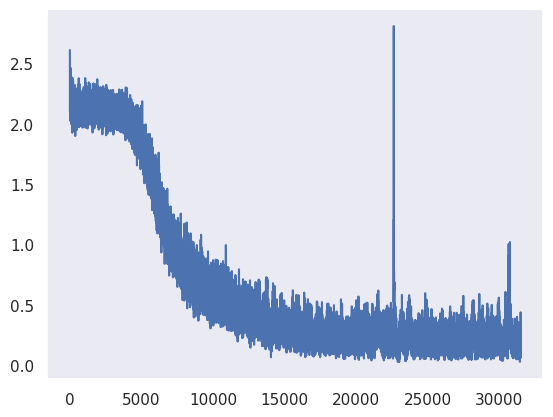

In [19]:
plt.plot(train_losses)

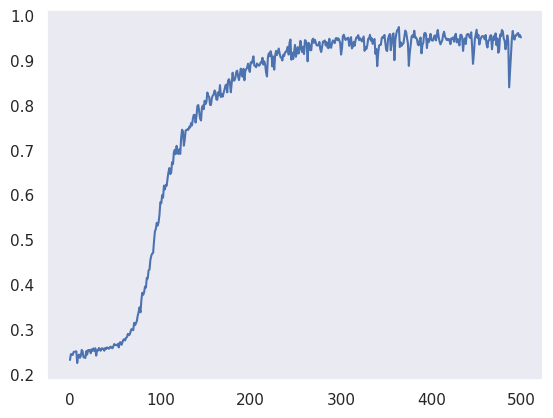

In [20]:
plt.plot(test_accuracy)

In [21]:
from torchmetrics import ConfusionMatrix

In [22]:
metric_cm = ConfusionMatrix(task='multiclass', num_classes=len(labels)).to(device)

In [23]:
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 7613/8000 (0.9516)
tensor([[  20,    0,    1,    0,    0,    0,    0,    0,    0,    0,    0,    1,
            0],
        [   0,   34,    0,    0,    0,    1,    0,    0,    1,    0,    0,    0,
            0],
        [   0,    0,  152,    1,    0,    0,    0,    3,    6,    0,    0,    0,
            3],
        [   0,    1,    2,  140,    1,    1,    2,    2,    1,    0,    1,    0,
            1],
        [   0,    0,    1,    1,  326,    0,    0,    5,    5,    1,   10,    1,
            5],
        [   0,    0,    1,    0,    0, 1002,    7,   12,   13,    0,    2,    0,
            5],
        [   0,    0,    1,    0,    2,    1,  260,    0,    1,    0,    0,    0,
            0],
        [   0,    0,    3,    0,    1,    7,    5,  735,    9,    0,    1,    4,
            3],
        [   0,    0,    5,    0,    1,   14,    0,    7, 1687,    1,    6,    1,
            6],
        [   0,    0,    3,    0,    1,    1,    0,    4,    5,  283,    3,    0,
            5],
  

In [24]:
len(train_losses)

31500

In [26]:
from einops import reduce

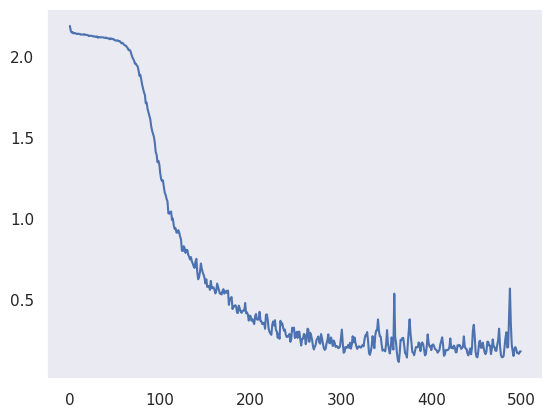

In [32]:
losses_epoch = reduce(np.array(train_losses), '(e n) -> e', 'mean',  e=500)
plt.plot(losses_epoch)

In [33]:
model_path = '_logs/iconnet_text_m11_v5.pt'
torch.save(model.state_dict(), model_path)

In [35]:
ckpt_path = '_logs/iconnet_text_m11_v5_epoch500.ckpt'
torch.save({
    'epoch': n_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'confusion_matrix': cm.cpu()
}, ckpt_path)

In [36]:
from matplotlib.lines import Line2D

In [38]:
import seaborn as sns

/tmp/ipykernel_2029762/2715343592.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels())


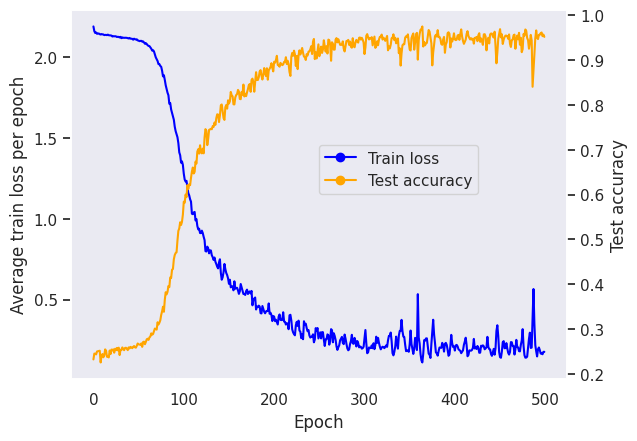

In [48]:
xval = np.arange(n_epoch)
y1val = losses_epoch
y2val = test_accuracy
g = sns.lineplot(x=xval, y=y1val, color='blue')
g2 = sns.lineplot(x=xval, y=y2val, color='orange', ax=g.axes.twinx())
g.set_xticklabels(g.get_xticklabels())
g.set_xlabel('Epoch')
g.set_ylabel('Average train loss per epoch')
g2.set_ylabel('Test accuracy')
g.legend(handles=[Line2D([], [], marker='o', color='blue', label='Train loss'), 
                  Line2D([], [], marker='o', color='orange', label='Test accuracy')], 
         loc=(0.5,0.5))

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

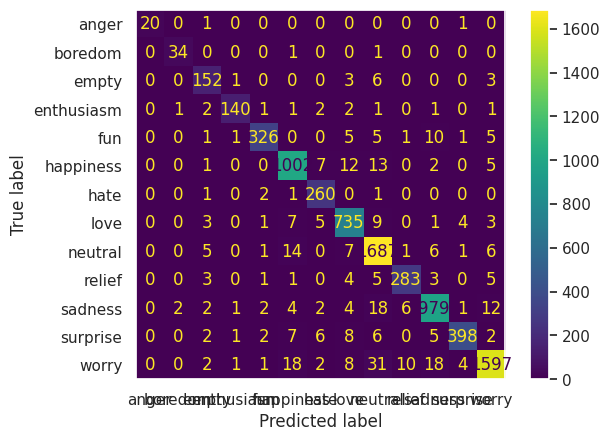

In [50]:
cm = cm.cpu().numpy()
ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels).plot()

<Axes: >

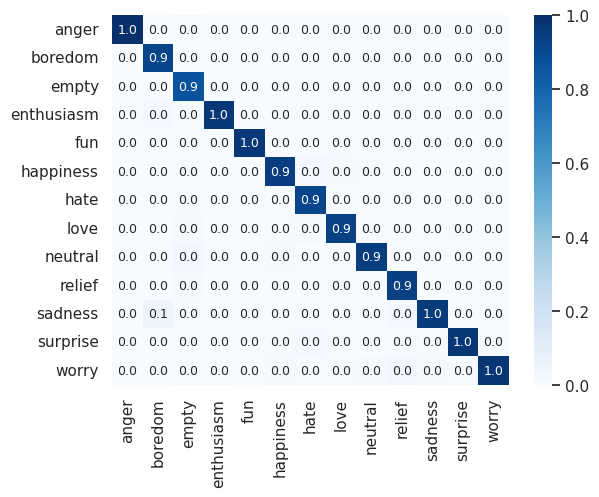

In [53]:
c = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
sns.heatmap(
    c, cmap="Blues", 
    annot=True,
    annot_kws={"size": 9},
    xticklabels=labels, 
    yticklabels=labels, fmt='.1f')

<Axes: >

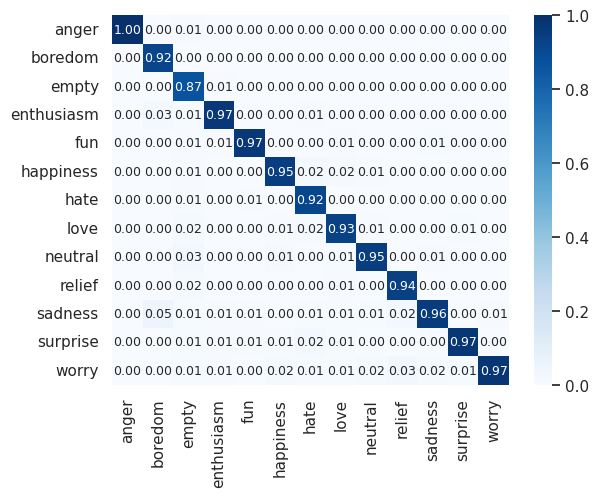

In [54]:
c = cm / reduce(cm, 'y yh -> 1 yh', 'sum')
sns.heatmap(
    c, cmap="Blues", 
    annot=True,
    annot_kws={"size": 9},
    xticklabels=labels, 
    yticklabels=labels, fmt='.2f')

In [57]:
import torchmetrics
n = len(labels)
wf1 = torchmetrics.F1Score(task='multiclass', num_classes=n).to(device)
uf1 = torchmetrics.F1Score(task='multiclass', num_classes=n, average='macro').to(device)
wap = torchmetrics.Precision(task='multiclass', num_classes=n, average='micro').to(device)    
uar = torchmetrics.Recall(task='multiclass', num_classes=n, average='macro').to(device)
model.to(device)
model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    wf1(pred, target)
    uf1(pred, target)
    wap(pred, target)
    uar(pred, target)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
WF1 = wf1.compute()
UF1 = uf1.compute()
WAP = wap.compute()
UAR = uar.compute()
print(f'WF1: {WF1}')
print(f'UF1: {UF1}')
print(f'WAP: {WAP}')
print(f'UAR: {UAR}')

Correct: 7613/8000 (0.9516)
WF1: 0.9516249895095825
UF1: 0.9427004456520081
WAP: 0.9516249895095825
UAR: 0.9400278329849243


In [55]:
layer_after = model.fe_blocks.blocks[0].layer.cpu()
visualize_model.print_parameters(layer_after)

('lowcut_bands', Parameter containing:
tensor([[0.0000, 0.0000, 0.0000],
        [0.0036, 0.0036, 0.0036],
        [0.0076, 0.0075, 0.0075],
        [0.0120, 0.0117, 0.0116],
        [0.0162, 0.0162, 0.0162],
        [0.0211, 0.0211, 0.0211],
        [0.0264, 0.0264, 0.0264],
        [0.0322, 0.0322, 0.0322],
        [0.0384, 0.0384, 0.0384],
        [0.0451, 0.0451, 0.0451],
        [0.0524, 0.0524, 0.0524],
        [0.0603, 0.0603, 0.0603],
        [0.0688, 0.0688, 0.0688],
        [0.0780, 0.0780, 0.0780],
        [0.0880, 0.0880, 0.0880],
        [0.0988, 0.0988, 0.0988],
        [0.1105, 0.1105, 0.1105],
        [0.1231, 0.1231, 0.1231],
        [0.1368, 0.1368, 0.1368],
        [0.1516, 0.1516, 0.1516],
        [0.1676, 0.1676, 0.1676],
        [0.1849, 0.1849, 0.1849],
        [0.2037, 0.2036, 0.2037],
        [0.2239, 0.2239, 0.2239],
        [0.2458, 0.2458, 0.2458],
        [0.2696, 0.2696, 0.2696],
        [0.2952, 0.2952, 0.2952],
        [0.3230, 0.3230, 0.3231],
        [

In [59]:
filtviz_after = visualize_model.FilterVisualizer(
    lowcut_bands = layer_after.lowcut_bands, 
    bandwidths = layer_after.bandwidths,
    window_params = layer_after.window_params, 
    window_length = 64,
    sample_rate = 75
)

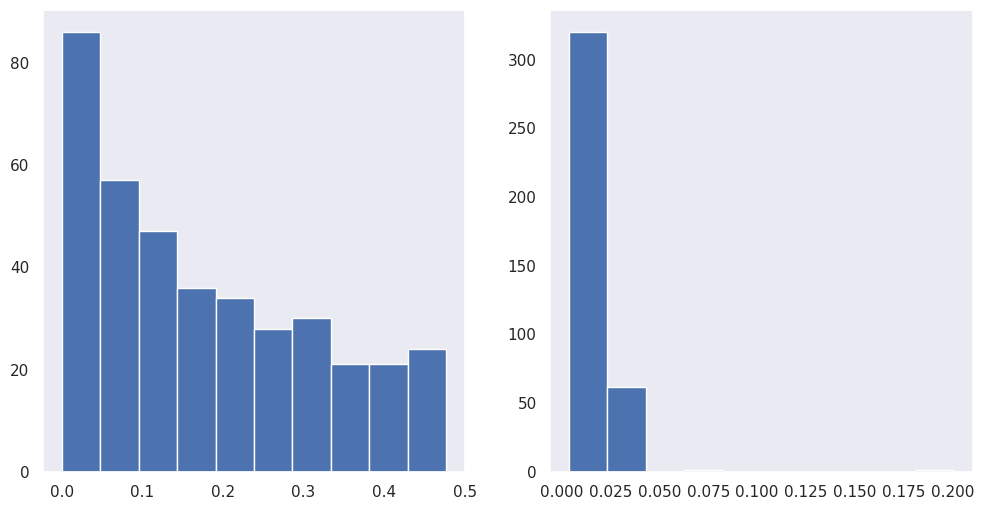

In [60]:
filtviz_after.visualize_bands()

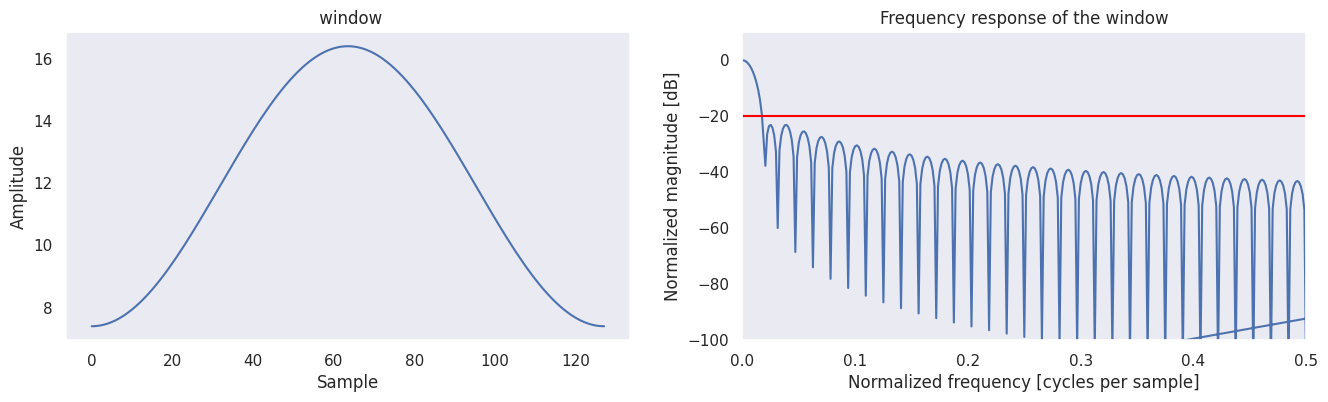

In [61]:
filtviz_after.visualize_one_window()

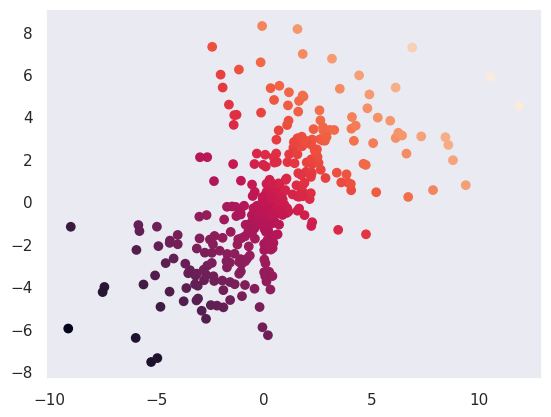

In [62]:
filtviz_after.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


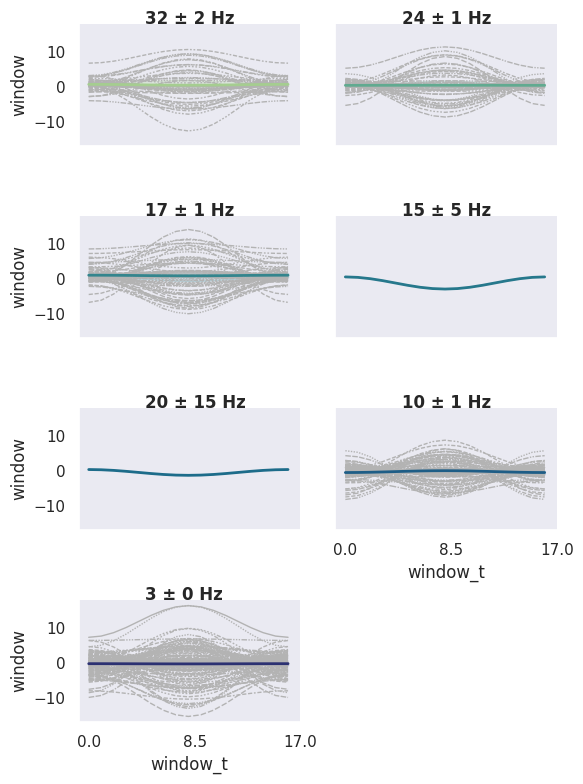

In [63]:
filtviz_after.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


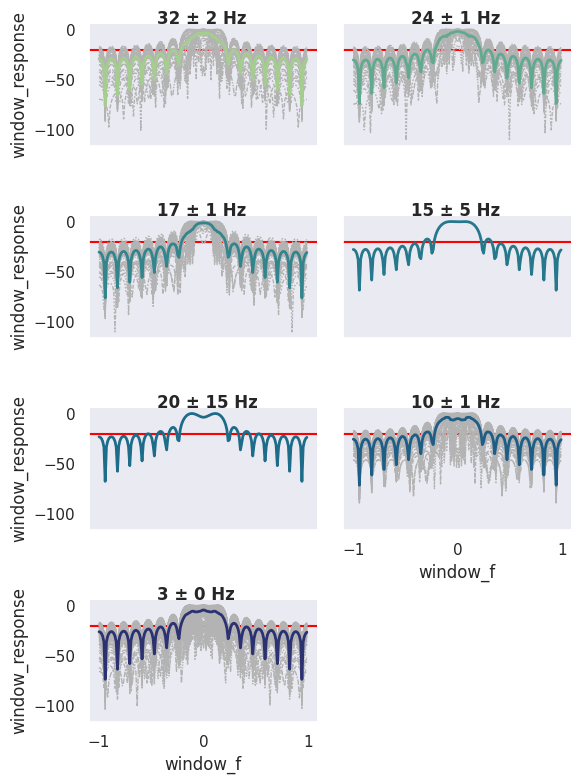

In [64]:
filtviz_after.visualize_filters(filter_domain='freq')